
*LMU Munich* \
*Machine Learning: Applications in Economic Research* 

---
<br>

# <center>Using machine learning methods to evaluate cross–country uncertainty and optimism</center>


**Submitted by:**

Moritz Dillmann \
Economics (M.Sc.) 

John Doncy \
Economics (M.Sc.) 

Lukas Franz \
Economics (M.Sc.) 

Bennet Niederhöfer \
Economics (M.Sc.) 

<br>

March 15, 2021

<br>

**Advisor** \
Dr. Thomas Fackler \
Department of Economics, ifo Institute


Helene Strandt \
Department of Economics

---

**This notebook comprises the Python code for our NLP analysis. The figures based on this code and reported in the submitted paper have been prepared using STATA.**

---

<br>

**Content**

i) Data Preparation

i) Uncertainty Index

iii) Optimism Index

iv) Comparing Indices

v) Spillovers

vi) Sentiment Analysis

vii) Topic Modelling using LDA

<br>

---

# Data

In [355]:
# Import packages and dataset
import geopandas as gpd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import string
import time
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.colors as mcolors
import warnings


from collections import Counter
from nltk.stem import PorterStemmer
from scipy.stats.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from wordcloud import WordCloud

#pd.set_option("display.max_rows", None, "display.max_columns", None)

#os.chdir("C:/Users/Bennet/OneDrive - bwedu/Dokumente/Studium/11 HWS2021/A_Machine Learning Applications in Economic Research/ML Project Winter 2021/Data/IMF")
os.chdir("/Users/moritzdillmann/iCloud/uni/wise_20_21/ml/group/")
#os.chdir("/Users/lukasfranz/Google Drive/Machine Learning")
input_path = 'Input_csv/'
output_path = 'Output/'
data_path = 'Data/'

warnings.filterwarnings('ignore')

df = pd.read_csv(input_path + "01_reports_long.csv", encoding = "ISO-8859-1", index_col=False)
#df = pd.read_csv(input_path + "02_reports_short.csv", encoding = "ISO-8859-1", index_col=False)


print("Shape:",df.shape)
df.head()

Shape: (8185, 23)


,report_id,issn,title,date,year,country,country_loc,country_ic,r_gdp,share_r_gdp,...,series,pages,file_name,start_url,report_link,file_link,article_four,use_nlp,do_have_pdf,report_text
0,B_280,9781451827033/1934-7685,Mozambique : Recent Economic Developments,23jan1997,1997,Mozambique,Africa,LIC,4.130669e+09,0.000091,...,Country Report No. 96/142,106.0,NaN,https://www.imf.org/en/Publications/Search?ser...,https://www.imf.org/en/Publications/CR/Issues/...,NaN,0.0,0.0,0.0,NaN
1,B_55,9781451811988/1934-7685,Spain : Selected Background Issues,16may1995,1995,Spain,Europe,HI,9.429490e+11,0.022345,...,Country Report No. 95/39,119.0,NaN,https://www.imf.org/en/Publications/Search?ser...,https://www.imf.org/en/Publications/CR/Issues/...,NaN,0.0,0.0,0.0,NaN
2,B_20,9781451808995/1934-7685,Comoros : Recent Economic Developments,23jan1995,1995,Comoros,Africa,LIC,5.982141e+08,0.000014,...,Country Report No. 94/6,79.0,NaN,https://www.imf.org/en/Publications/Search?ser...,https://www.imf.org/en/Publications/CR/Issues/...,NaN,0.0,0.0,0.0,NaN
3,B_252,9781451813753/1934-7685,Federated States of Micronesia : Recent Econom...,15oct1996,1996,Micronesia,Asia and the Pacific,LMC,2.832095e+08,0.000006,...,Country Report No. 96/107,33.0,NaN,https://www.imf.org/en/Publications/Search?ser...,https://www.imf.org/en/Publications/CR/Issues/...,NaN,0.0,0.0,0.0,NaN
4,B_358,9781451804089/1934-7685,Bangladesh : Statistical Appendix,31oct1997,1997,Bangladesh,Asia and the Pacific,LIC,5.781195e+10,0.001279,...,Country Report No. 97/85,46.0,NaN,https://www.imf.org/en/Publications/Search?ser...,https://www.imf.org/en/Publications/CR/Issues/...,NaN,0.0,0.0,0.0,NaN


In [356]:
# Prepare sample
print("Full sample:", df.shape)

#Drop all special reports (e.g., Selected Issues)
df_nlp = df.loc[df['use_nlp'] == 1]
print("Shape w/ NaN:", df_nlp.shape)

# Ensure that all reports we use are Article IV reports
df_nlp_iv = df_nlp.loc[df['article_four'] == 1]
print("Shape w/ NaN, IV:", df_nlp_iv.shape)

# drop missing values in report_text
df_nlp_iv_nan = df_nlp_iv.dropna(subset=['report_text'])
print("Shape w/o NaN, IV:", df_nlp_iv_nan.shape)

# Rename dataframe 
df = df_nlp_iv_nan

# Keep only relevant columns
df = df[["report_id", "country", "year", "report_text"]].copy()
print("Shape final sample:", df.shape)

df.head()

Full sample: (8185, 23)
Shape w/ NaN: (1844, 23)
Shape w/ NaN, IV: (1844, 23)
Shape w/o NaN, IV: (1844, 23)
Shape final sample: (1844, 4)


,report_id,country,year,report_text
402,B_7558,Aruba,2019,...
406,B_7787,Afghanistan,2019,...
423,B_7559,Armenia,2019,...
436,B_7466,Australia,2018,...
438,B_7872,Australia,2019,...


## Cleaning the report_text column

In [353]:
def clean_text(text):
    # Remove numbers
    text_nonum = re.sub(r'\d+', '', str(text))
    
    # Remove punctuation
    text_nopunct = re.sub(r'[^\w\s]','', text_nonum)
    
    # Remove line spacing
    text_line = text_nopunct.strip().replace('\n', ' ')
    
    # Remove unidentified apostrophes
    text_apostr = text_line.strip().replace('ÃÂÂ', ' ')
    
    # Remove all spaces but single spaces
    text_nodoublespace = re.sub(r'\s+', ' ', text_apostr).strip()
    return text_nodoublespace

df['report_clean_text'] = df['report_text'].apply(lambda x: clean_text(str(x)))

df.report_clean_text.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


402    IMF Country Report No KINGDOM OF THE NETHERLAN...
406    IMF Country Report No ISLAMIC REPUBLIC OF AFGH...
423    IMF Country Report No REPUBLIC OF ARMENIA ARTI...
436    IMF Country Report No AUSTRALIA ARTICLE IV CON...
438    IMF Country Report No AUSTRALIA ARTICLE IV CON...
Name: report_clean_text, dtype: object

In [5]:
# Tokenization
def tokenize(text):
    split = re.split(r"\W+", text)
    return split
df['report_text_token'] = df['report_clean_text'].apply(lambda x: tokenize(x.lower()))

df["report_text_token"].head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


402    [imf, country, report, no, kingdom, of, the, n...
406    [imf, country, report, no, islamic, republic, ...
423    [imf, country, report, no, republic, of, armen...
436    [imf, country, report, no, australia, article,...
438    [imf, country, report, no, australia, article,...
Name: report_text_token, dtype: object

In [6]:
# Stemming
ps = PorterStemmer()

def stem_words(words):
    stemmed_tokens = [ps.stem(word) for word in words]
    return stemmed_tokens

df['report_text_token_stemm'] = df['report_text_token'].apply(stem_words)

df["report_text_token_stemm"].head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


402    [imf, countri, report, no, kingdom, of, the, n...
406    [imf, countri, report, no, islam, republ, of, ...
423    [imf, countri, report, no, republ, of, armenia...
436    [imf, countri, report, no, australia, articl, ...
438    [imf, countri, report, no, australia, articl, ...
Name: report_text_token_stemm, dtype: object

In [7]:
# Removing stop words

# nltk.download('stopwords')

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
df['report_text_token_stemm_stop'] = df['report_text_token_stemm'].apply(lambda x: remove_stopwords(x))

#df.loc[4, "report_text_token_stemm_stop"]

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Rename cleaned text column
df['report_text_clean'] = df['report_text_token_stemm_stop']

df = df.drop(columns = "report_text")
df = df.drop(columns = "report_clean_text")
df = df.drop(columns = "report_text_token")
df = df.drop(columns = "report_text_token_stemm")
df = df.drop(columns = "report_text_token_stemm_stop")

df.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar..."
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis..."
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl..."
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ..."
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ..."


# Uncertainty index

## Generate set of words

Idea: randomly select number of other words related to uncertainty that are marked as "most relevant" in the Thesaurus dictionary.

"Uncertainty" (https://www.thesaurus.com/browse/uncertainty?s=t)

- ambiguity
- ambivalence
- anxiety
- concern
- confusion
- distrust
- mistrust
- skepticism
- suspicion
- trouble
- uneasiness
- unpredictability
- worry

In [9]:
# Randomly select sets of words

# Define list of words from above
uncertainty_thesaurus = ['ambiguity', 'ambivalence', 'anxiety', 
                         'concern', 'confusion', 'distrust', 
                         'mistrust', 'skeptisism', 'suspicion', 
                         'trouble', 'uneasiness', 'unpredictability', 
                         'worry']

# Set 1: two words
uncertainty_syn_1 = random.sample(uncertainty_thesaurus, 2)

# Set 2: two words not in first random set
uncertainty_thesaurus_d = list((Counter(uncertainty_thesaurus) 
                        - Counter(uncertainty_syn_1)).elements())

uncertainty_syn_2 = random.sample(uncertainty_thesaurus_d, 2)

# Set 3: five words
uncertainty_syn_3 = random.sample(uncertainty_thesaurus, 5)


# Assign drawn words for further use
uncertainty_syn_1_1_stem = ps.stem(uncertainty_syn_1[0])
uncertainty_syn_1_2_stem = ps.stem(uncertainty_syn_1[1])

uncertainty_syn_2_1_stem = ps.stem(uncertainty_syn_2[0])
uncertainty_syn_2_2_stem = ps.stem(uncertainty_syn_2[1])

uncertainty_syn_3_1_stem = ps.stem(uncertainty_syn_3[0])
uncertainty_syn_3_2_stem = ps.stem(uncertainty_syn_3[1])
uncertainty_syn_3_3_stem = ps.stem(uncertainty_syn_3[2])
uncertainty_syn_3_4_stem = ps.stem(uncertainty_syn_3[3])
uncertainty_syn_3_5_stem = ps.stem(uncertainty_syn_3[4])


print("Random samples selected for 'uncertainty'.")
print("1st random sample:", uncertainty_syn_1_1_stem, uncertainty_syn_1_2_stem)
print("2nd random sample:", uncertainty_syn_2_1_stem, uncertainty_syn_2_2_stem)
print("3rd random sample:", uncertainty_syn_3_1_stem, uncertainty_syn_3_2_stem, 
                            uncertainty_syn_3_3_stem, uncertainty_syn_3_4_stem, \
                            uncertainty_syn_3_5_stem)

Random samples selected for 'uncertainty'.
1st random sample: uneasi confus
2nd random sample: worri mistrust
3rd random sample: troubl uneasi ambival distrust worri


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Term frequency

In [10]:
# Number of words per report (stop words removed)
df['report_text_clean_words'] = df['report_text_clean'].str.len()

df.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean,report_text_clean_words
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar...",13458
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis...",27449
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl...",27556
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ...",15589
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ...",17037


In [11]:
# Get stems of "uncertainty" variants 
print(ps.stem('uncertainties'))
print(ps.stem('uncertainty'))
print(ps.stem('uncertain'))
print(ps.stem('uncertainness'))

uncertainti
uncertainti
uncertain
uncertain


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Count stems in every report

# "uncertainty"
df['no_uncertainti'] = df['report_text_clean'].map(lambda x: x.count("uncertainti"))
df['no_uncertain'] = df['report_text_clean'].map(lambda x: x.count("uncertain"))


# Random sample 1
df['no_' + str(uncertainty_syn_1_1_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_1_1_stem))
df['no_' + str(uncertainty_syn_1_2_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_1_2_stem))


# Random sample 2
df['no_' + str(uncertainty_syn_2_1_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_2_1_stem))
df['no_' + str(uncertainty_syn_2_2_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_2_2_stem))


# Random sample 3
df['no_' + str(uncertainty_syn_3_1_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_3_1_stem))
df['no_' + str(uncertainty_syn_3_2_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_3_2_stem))
df['no_' + str(uncertainty_syn_3_3_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_3_3_stem))
df['no_' + str(uncertainty_syn_3_4_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_3_4_stem))
df['no_' + str(uncertainty_syn_3_5_stem)] = df['report_text_clean'].map(lambda x: x.count(uncertainty_syn_3_5_stem))

df.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean,report_text_clean_words,no_uncertainti,no_uncertain,no_uneasi,no_confus,no_worri,no_mistrust,no_troubl,no_ambival,no_distrust
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar...",13458,1,2,0,0,0,0,0,0,0
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis...",27449,30,8,0,0,0,0,0,0,0
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl...",27556,5,1,0,0,0,0,0,0,0
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ...",15589,11,2,0,0,0,0,0,0,0
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ...",17037,30,3,0,0,0,0,0,0,0


In [13]:
# Construct sum of word counts for index

# "uncertainty" (and its variant) only
df['total_uncertainty'] = (df['no_uncertainti'] 
                           + df['no_uncertain'])


# "uncertainty" & random sample 1
df['total_uncertainty_r1'] = (df['no_uncertainti'] 
                              + df['no_uncertain'] 
                              + df['no_' + str(uncertainty_syn_1_1_stem)] 
                              + df['no_' + str(uncertainty_syn_1_2_stem)])

# "uncertainty" & random sample 2
df['total_uncertainty_r2'] = (df['no_uncertainti'] 
                              + df['no_uncertain'] 
                              + df['no_' + str(uncertainty_syn_2_1_stem)] 
                              + df['no_' + str(uncertainty_syn_2_2_stem)])

# "uncertainty" & random sample 3
df['total_uncertainty_r3'] = (df['no_uncertainti'] 
                              + df['no_uncertain'] 
                              + df['no_' + str(uncertainty_syn_3_1_stem)] 
                              + df['no_' + str(uncertainty_syn_3_2_stem)] 
                              + df['no_' + str(uncertainty_syn_3_3_stem)] 
                              + df['no_' + str(uncertainty_syn_3_4_stem)] 
                              + df['no_' + str(uncertainty_syn_3_5_stem)])

df[['report_id', 'country', 'year', 'report_text_clean', 'report_text_clean_words', 
    'total_uncertainty', 'total_uncertainty_r1', 'total_uncertainty_r2', 
    'total_uncertainty_r3']].head()


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean,report_text_clean_words,total_uncertainty,total_uncertainty_r1,total_uncertainty_r2,total_uncertainty_r3
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar...",13458,3,3,3,3
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis...",27449,38,38,38,38
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl...",27556,6,6,6,6
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ...",15589,13,13,13,13
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ...",17037,33,33,33,33


## Uncertainty Index over time (unweighted)

The World Uncertainty Index (WUI) is computed by counting the *percent* of the word "uncertain" (or its variants) in the *Economist Intelligence Unit* reports. The WUI is then rescaled by being multiplied with 1,000,000. For example, an index of 200 corresponds to the word 'uncertainty' accounting for 0.02 percent of all words in a report. (https://blogs.imf.org/2021/01/19/what-the-continued-global-uncertainty-means-for-you/)

In [14]:
# Generate the total number of words across all reports in a given year

# Generate dataframe
df_year_words = pd.DataFrame()

df_year_words['words_year'] = df.groupby(['year'])['report_text_clean_words'].sum()
df_year_words = df_year_words.reset_index()

df_year_words

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,words_year
0,2004,1441934
1,2005,1525083
2,2006,1464439
3,2007,1397712
4,2008,1386209
5,2009,1362423
6,2010,1551932
7,2011,1583661
8,2012,1760920
9,2013,1796611


In [15]:
# Generate total number of uncertainty measures over time

# Generate dataframe
df_year_uncertainty = pd.DataFrame()

# "uncertainty" (and its variant) only
df_year_uncertainty['uncertainty_year'] = df.groupby(['year'])['total_uncertainty'].sum()

# "uncertainty" & random sample 1
df_year_uncertainty['uncertainty_year_r1'] = df.groupby(['year'])['total_uncertainty_r1'].sum()

# "uncertainty" & random sample 2
df_year_uncertainty['uncertainty_year_r2'] = df.groupby(['year'])['total_uncertainty_r2'].sum()

# "uncertainty" & random sample 3
df_year_uncertainty['uncertainty_year_r3'] = df.groupby(['year'])['total_uncertainty_r3'].sum()

df_year_uncertainty = df_year_uncertainty.reset_index()

df_year_uncertainty

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,uncertainty_year,uncertainty_year_r1,uncertainty_year_r2,uncertainty_year_r3
0,2004,453,467,465,485
1,2005,423,431,431,462
2,2006,381,386,394,410
3,2007,354,362,357,387
4,2008,499,505,506,536
5,2009,655,661,659,730
6,2010,693,703,702,745
7,2011,687,691,693,724
8,2012,762,770,771,831
9,2013,990,993,1001,1034


In [16]:
# Combine to index

# Generate dataframe
df_uncertainty_index_time = pd.DataFrame()

# Add year to dataframe
df_uncertainty_index_time['year'] = df_year_uncertainty['year']

# Calculate word frequency as percentage share
df_uncertainty_index_time['index_value'] = ((df_year_uncertainty['uncertainty_year'] 
                                             / df_year_words['words_year']) * 100)

df_uncertainty_index_time['index_value_r1'] = ((df_year_uncertainty['uncertainty_year_r1'] 
                                                / df_year_words['words_year']) * 100)

df_uncertainty_index_time['index_value_r2'] = ((df_year_uncertainty['uncertainty_year_r2'] 
                                                / df_year_words['words_year']) * 100)

df_uncertainty_index_time['index_value_r3'] = ((df_year_uncertainty['uncertainty_year_r3'] 
                                                / df_year_words['words_year']) * 100)

# Rescale by multiplying by 1,000,000
df_uncertainty_index_time['index_value_rescaled'] = df_uncertainty_index_time['index_value'] * 1000000
df_uncertainty_index_time['index_value_rescaled_r1'] = df_uncertainty_index_time['index_value_r1'] * 1000000
df_uncertainty_index_time['index_value_rescaled_r2'] = df_uncertainty_index_time['index_value_r2'] * 1000000
df_uncertainty_index_time['index_value_rescaled_r3'] = df_uncertainty_index_time['index_value_r3'] * 1000000

df_uncertainty_index_time

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,index_value,index_value_r1,index_value_r2,index_value_r3,index_value_rescaled,index_value_rescaled_r1,index_value_rescaled_r2,index_value_rescaled_r3
0,2004,0.031416,0.032387,0.032248,0.033635,31416.139712,32387.057937,32248.355334,33635.381370
1,2005,0.027736,0.028261,0.028261,0.030293,27736.195341,28260.756956,28260.756956,30293.433210
2,2006,0.026017,0.026358,0.026905,0.027997,26016.788682,26358.216355,26904.500631,27997.069185
3,2007,0.025327,0.025899,0.025542,0.027688,25327.106013,25899.469991,25541.742505,27688.107421
4,2008,0.035997,0.036430,0.036502,0.038667,35997.457815,36430.292979,36502.432173,38666.607993
5,2009,0.048076,0.048517,0.048370,0.053581,48076.111457,48516.503318,48369.706031,53581.009716
6,2010,0.044654,0.045298,0.045234,0.048005,44654.018346,45298.376475,45233.940662,48004.680617
7,2011,0.043380,0.043633,0.043759,0.045717,43380.496205,43633.075513,43759.365167,45716.854807
8,2012,0.043273,0.043727,0.043784,0.047191,43272.834655,43727.142630,43783.931127,47191.240942
9,2013,0.055104,0.055271,0.055716,0.057553,55103.748112,55270.729167,55716.011980,57552.803584


In [17]:
# Export to csv
df_uncertainty_index_time.to_csv(output_path + r'01_df_uncertainty_index_time.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

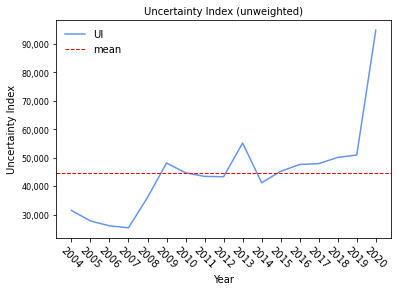

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot index over time ("uncertainty" and its variants only)

# Sort dataframe according to year
df_uncertainty_index_time = df_uncertainty_index_time.sort_values(by = ['year'], ascending = True)

# Assign plot contents
year = df_uncertainty_index_time['year']
index_value_rescaled = df_uncertainty_index_time['index_value_rescaled']

index_value_rescaled_mean = df_uncertainty_index_time['index_value_rescaled'].mean()

# Generate plot
fig1 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled, 'cornflowerblue', label = 'UI')
plt.axhline(y = index_value_rescaled_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Uncertainty Index', fontsize = 10)
plt.title('Uncertainty Index (unweighted)', fontsize = 10)
plt.yticks([30000, 40000, 50000, 60000, 70000, 80000, 90000],
           ['30,000', '40,000', '50,000', '60,000', '70,000', '80,000', '90,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(loc='upper left', frameon=False)
plt.show()
plt.savefig(output_path + '01_ui_time_unweighted.png')

In [349]:
# Plot index over time (including robustness checks)

# Assign plot contents
index_value_rescaled = df_uncertainty_index_time['index_value_rescaled']
index_value_rescaled_r1 = df_uncertainty_index_time['index_value_rescaled_r1']
index_value_rescaled_r2 = df_uncertainty_index_time['index_value_rescaled_r2']
index_value_rescaled_r3 = df_uncertainty_index_time['index_value_rescaled_r3']

index_value_rescaled_mean = df_uncertainty_index_time['index_value_rescaled'].mean()

# Generate plot
fig2 = plt.figure(figsize=(14,6))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled, 'cornflowerblue', label = 'uncertainty & variant')
plt.plot(year, index_value_rescaled_r1, 'salmon', label = 'r1')
plt.plot(year, index_value_rescaled_r2, 'darkorange', label = 'r2')
plt.plot(year, index_value_rescaled_r3, 'forestgreen', label = 'r3')
plt.axhline(y = index_value_rescaled_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Uncertainty Indices', fontsize = 10)
plt.title('Uncertainty Indices including robustness (unweighted)', fontsize = 10)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000],
           ['20,000', '40,000', '60,000', '80,000', '100,000', '120,000', '140,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(loc='upper left', frameon=False);
plt.show()

plt.savefig(output_path + '02_ui_time_unweighted_r.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'index_value_rescaled_r1'

## Uncertainty Index per country

In [20]:
# Generate total number of words for a given country

# Generate Dataframe
df_country_words = pd.DataFrame()

df_country_words['words_country'] = df.groupby(['country'])['report_text_clean_words'].sum()
df_country_words = df_country_words.reset_index()

df_country_words.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,words_country
0,Afghanistan,188184
1,Albania,190119
2,Algeria,149847
3,Angola,98133
4,Anguilla,6748


In [21]:
# Generate total number of "uncertainty" (and its variant) per country
df_country_uncertainty = pd.DataFrame()

df_country_uncertainty['uncertainty_country'] = df.groupby(['country'])['total_uncertainty'].sum()
df_country_uncertainty['uncertainty_country_r3'] = df.groupby(['country'])['total_uncertainty_r3'].sum()

df_country_uncertainty = df_country_uncertainty.reset_index()

df_country_uncertainty.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,uncertainty_country,uncertainty_country_r3
0,Afghanistan,136,138
1,Albania,53,58
2,Algeria,28,30
3,Angola,30,30
4,Anguilla,1,1


In [22]:
# Combine to index

# Generate dataframe
df_uncertainty_index_country = pd.DataFrame()

# Add country to dataframe
df_uncertainty_index_country['country'] = df_country_uncertainty['country']

# Calculate word frequency as percentage share
df_uncertainty_index_country['index_value'] = (df_country_uncertainty['uncertainty_country'] / df_country_words['words_country']) * 100
df_uncertainty_index_country['index_value_r3'] = (df_country_uncertainty['uncertainty_country_r3'] / df_country_words['words_country']) * 100

# Rescale by multiplying by 1,000,000
df_uncertainty_index_country['index_value_rescaled'] = df_uncertainty_index_country['index_value'] * 1000000
df_uncertainty_index_country['index_value_rescaled_r3'] = df_uncertainty_index_country['index_value_r3'] * 1000000


df_uncertainty_index_country.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,index_value,index_value_r3,index_value_rescaled,index_value_rescaled_r3
0,Afghanistan,0.072270,0.073332,72269.693491,73332.483102
1,Albania,0.027877,0.030507,27877.276863,30507.208643
2,Algeria,0.018686,0.020020,18685.726107,20020.420829
3,Angola,0.030571,0.030571,30570.756015,30570.756015
4,Anguilla,0.014819,0.014819,14819.205691,14819.205691


In [23]:
# Export to csv
df_uncertainty_index_country.to_csv(output_path + r'02_df_uncertainty_index_country.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


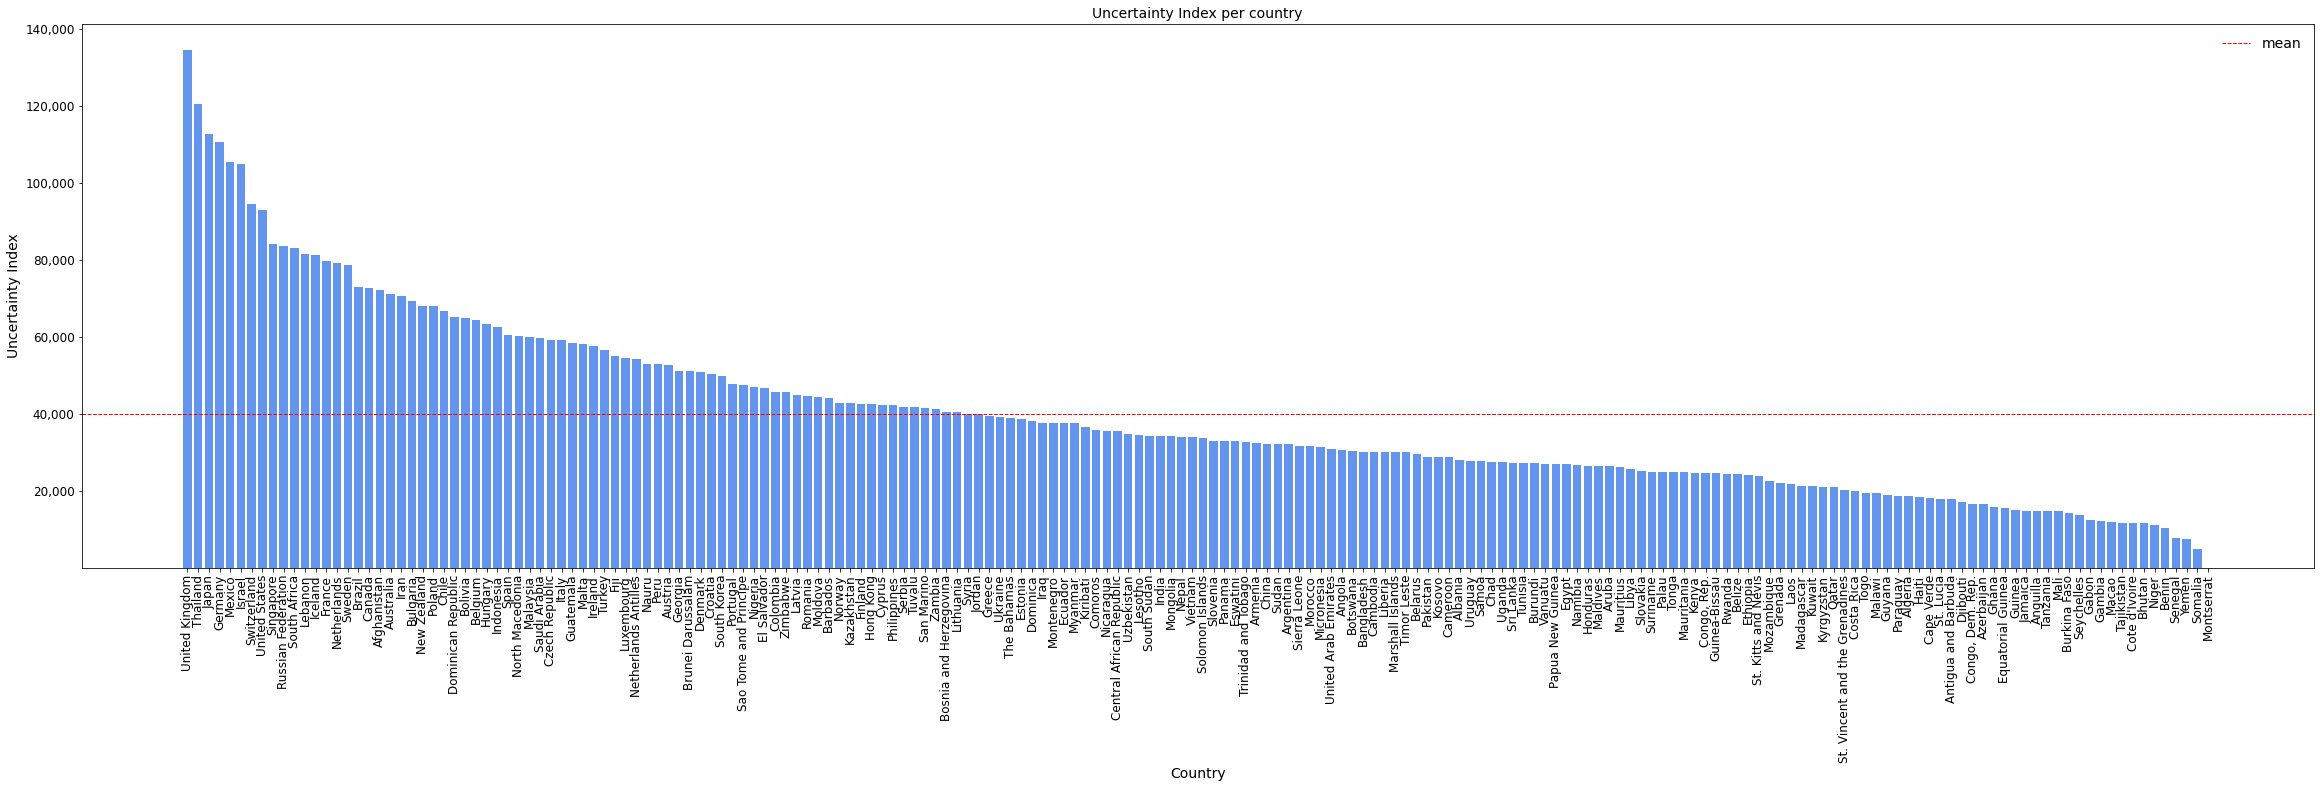

In [348]:
# Plot index per country ("uncertainty" (and its variant) only)

# Sort dataframe according to index value
df_uncertainty_index_country = df_uncertainty_index_country.sort_values(by = ['index_value_rescaled'], ascending = False)

# Assign plot contents
country = df_uncertainty_index_country['country']
index_value_rescaled = df_uncertainty_index_country['index_value_rescaled']

index_value_rescaled_mean = df_uncertainty_index_country['index_value_rescaled'].mean()

# Generate plot
fig, ax = plt.subplots(figsize=(40,10))
plt.xticks(rotation = 90)
plt.bar(country, index_value_rescaled, color = 'cornflowerblue')
plt.axhline(y = index_value_rescaled_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.xlabel('Country', fontsize = 14)
plt.ylabel('Uncertainty Index', fontsize = 14)
plt.title('Uncertainty Index per country', fontsize = 14)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000],
           ['20,000', '40,000', '60,000', '80,000', '100,000', '120,000', '140,000'], fontsize = 12)
plt.xticks(fontsize = 12)
leg = ax.legend(loc='upper right', frameon=False, fontsize = 14);
plt.show()

#plt.savefig(output_path + '03_ui_country.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


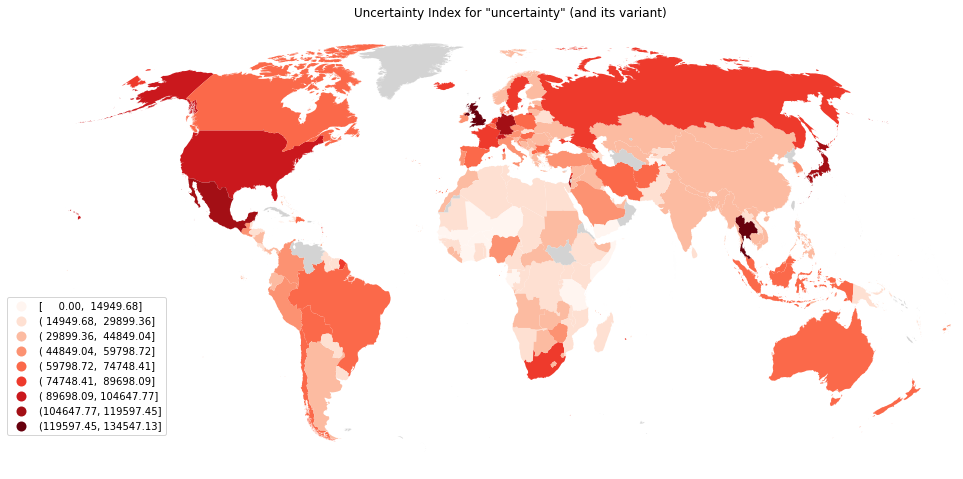

In [25]:
# Plot world map ("uncertainty" (and its variant) only)  
#(see: https://ramiro.org/notebook/geopandas-choropleth/)
shapefile = os.path.expanduser(input_path + '/shp_countries/ne_10m_admin_0_countries.shp')
isofile = os.path.expanduser(input_path + '/iso_3_codes.csv')

colors = 9
cmap = 'Reds'
figsize = (16, 10)
scheme = 'equal_interval'
title = 'Uncertainty Index for "uncertainty" (and its variant)'

gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
df_iso = pd.read_csv(isofile)
df_map = df_uncertainty_index_country

merged = gdf.merge(df_iso, left_on = 'ADM0_A3', right_on = 'country_iso3', how = 'outer')

merged = merged.merge(df_map, left_on = 'country', right_on = 'country', how = 'outer')
merged = merged[merged.ADM0_A3 != 'ATA']

ax = merged.dropna().plot(column = 'index_value_rescaled', cmap = cmap, figsize = figsize, scheme = scheme, k = colors, legend = True)
merged[merged.isna().any(axis = 1)].plot(ax = ax, color = 'lightgrey')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title(title, fontdict = {'fontsize': 12}, loc = 'center')

plt.savefig(output_path + '04_map_ui.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


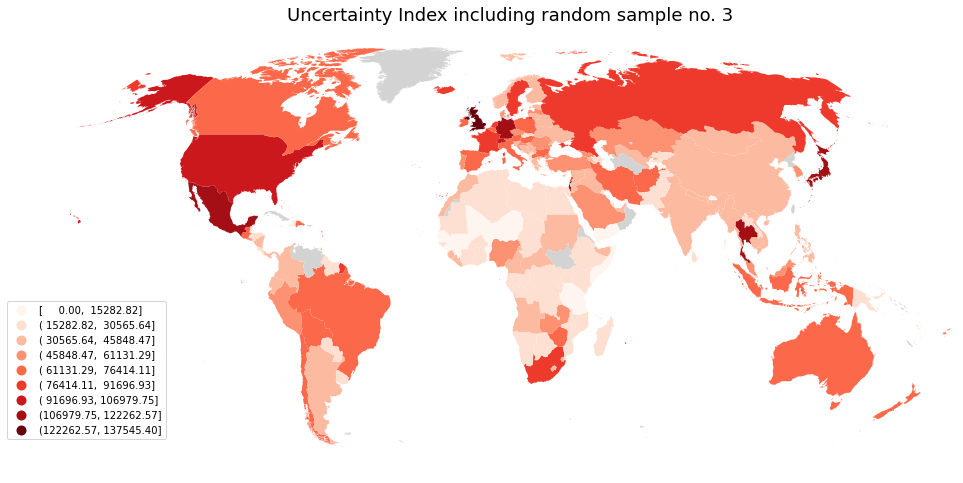

In [26]:
# Plot world map (including random sample three)
shapefile = os.path.expanduser(input_path + '/shp_countries/ne_10m_admin_0_countries.shp')
isofile = os.path.expanduser(input_path + '/iso_3_codes.csv')

colors = 9
cmap = 'Reds'
figsize = (16, 10)
scheme = 'equal_interval'
title = 'Uncertainty Index including random sample no. 3'

gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
df_iso = pd.read_csv(isofile)
df_map = df_uncertainty_index_country

merged = gdf.merge(df_iso, left_on = 'ADM0_A3', right_on = 'country_iso3', how = 'outer')

merged = merged.merge(df_map, left_on = 'country', right_on = 'country', how = 'outer')
merged = merged[merged.ADM0_A3 != 'ATA']

ax = merged.dropna().plot(column = 'index_value_rescaled_r3', cmap = cmap, figsize = figsize, \
                          scheme = scheme, k = colors, legend = True)
merged[merged.isna().any(axis = 1)].plot(ax = ax, color = 'lightgrey')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title(title, fontdict = {'fontsize': 12}, loc = 'center')

plt.savefig(output_path + '05_map_ui_r3.png')

## Uncertainty Index over time (weighted by real GDP)

In [27]:
# Generate total number of words in reports per country per year

# Generate dataframe
df_country_year_uncertainty_1 = pd.DataFrame()

# Generate total number of words per country per year
df_country_year_uncertainty_1['words_year_country'] = df.groupby(['country', 'year'])['report_text_clean_words'].sum()
df_country_year_uncertainty_1 = df_country_year_uncertainty_1.reset_index()

# Generate unique merge ID
df_country_year_uncertainty_1['year'] = df_country_year_uncertainty_1['year'].map(str)
df_country_year_uncertainty_1['country_year_id'] = (df_country_year_uncertainty_1['country'] 
                                                    + '_' 
                                                    + df_country_year_uncertainty_1['year'])


df_country_year_uncertainty_1.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id
0,Afghanistan,2004,15287,Afghanistan_2004
1,Afghanistan,2005,16002,Afghanistan_2005
2,Afghanistan,2007,20880,Afghanistan_2007
3,Afghanistan,2011,32283,Afghanistan_2011
4,Afghanistan,2014,22779,Afghanistan_2014


In [28]:
# Generate total number of uncertainty measures per country per year

# Generate dataframe
df_country_year_uncertainty_2 = pd.DataFrame()

# "uncertainty" (and its variant) only
df_country_year_uncertainty_2['uncertainty_year_country'] = df.groupby(['country', 'year'])['total_uncertainty'].sum()

# "uncertainty" plus random sample 1
df_country_year_uncertainty_2['uncertainty_year_country_r1'] = df.groupby(['country', 'year'])['total_uncertainty_r1'].sum()

# "uncertainty" plus random sample 2
df_country_year_uncertainty_2['uncertainty_year_country_r2'] = df.groupby(['country', 'year'])['total_uncertainty_r2'].sum()

# "uncertainty" plus random sample 3
df_country_year_uncertainty_2['uncertainty_year_country_r3'] = df.groupby(['country', 'year'])['total_uncertainty_r3'].sum()


df_country_year_uncertainty_2 = df_country_year_uncertainty_2.reset_index()


# Generate unique merge ID
df_country_year_uncertainty_2['year'] = df_country_year_uncertainty_2['year'].map(str)
df_country_year_uncertainty_2['country_year_id'] = (df_country_year_uncertainty_2['country'] 
                                                    + '_' 
                                                    + df_country_year_uncertainty_2['year'])


df_country_year_uncertainty_2.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,uncertainty_year_country,uncertainty_year_country_r1,uncertainty_year_country_r2,uncertainty_year_country_r3,country_year_id
0,Afghanistan,2004,5,5,5,5,Afghanistan_2004
1,Afghanistan,2005,10,10,10,10,Afghanistan_2005
2,Afghanistan,2007,3,4,3,3,Afghanistan_2007
3,Afghanistan,2011,11,11,11,12,Afghanistan_2011
4,Afghanistan,2014,31,31,31,32,Afghanistan_2014


In [29]:
# Merge word and stemm frequency frames

# Generate dataframe
df_country_year_uncertainty = pd.DataFrame()

# Only keep relevant columns for uncertainty
df_country_year_uncertainty_2 = df_country_year_uncertainty_2[['uncertainty_year_country', 'uncertainty_year_country_r1', 
                                                               'uncertainty_year_country_r2', 'uncertainty_year_country_r3', 
                                                               'country_year_id']]

# Merge dataframes
df_country_year_uncertainty = df_country_year_uncertainty_1.merge(df_country_year_uncertainty_2, 
                                                                  left_on = 'country_year_id', right_on = 'country_year_id')

df_country_year_uncertainty.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id,uncertainty_year_country,uncertainty_year_country_r1,uncertainty_year_country_r2,uncertainty_year_country_r3
0,Afghanistan,2004,15287,Afghanistan_2004,5,5,5,5
1,Afghanistan,2005,16002,Afghanistan_2005,10,10,10,10
2,Afghanistan,2007,20880,Afghanistan_2007,3,4,3,3
3,Afghanistan,2011,32283,Afghanistan_2011,11,11,11,12
4,Afghanistan,2014,22779,Afghanistan_2014,31,31,31,32


In [30]:
# Generate index value for every country for every year

# Calculate word frequency as percentage share
df_country_year_uncertainty['index_value'] = ((df_country_year_uncertainty['uncertainty_year_country'] 
                                               / df_country_year_uncertainty['words_year_country']) 
                                              * 100)

df_country_year_uncertainty['index_value_r1'] = ((df_country_year_uncertainty['uncertainty_year_country_r1'] 
                                                  / df_country_year_uncertainty['words_year_country']) 
                                                 * 100)

df_country_year_uncertainty['index_value_r2'] = ((df_country_year_uncertainty['uncertainty_year_country_r2'] 
                                                  / df_country_year_uncertainty['words_year_country']) 
                                                 * 100)
df_country_year_uncertainty['index_value_r3'] = ((df_country_year_uncertainty['uncertainty_year_country_r3'] 
                                                  / df_country_year_uncertainty['words_year_country']) 
                                                 * 100)

# Rescale by multiplying by 1,000,000
df_country_year_uncertainty['index_value_rescaled'] = df_country_year_uncertainty['index_value'] * 1000000
df_country_year_uncertainty['index_value_rescaled_r1'] = df_country_year_uncertainty['index_value_r1'] * 1000000
df_country_year_uncertainty['index_value_rescaled_r2'] = df_country_year_uncertainty['index_value_r2'] * 1000000
df_country_year_uncertainty['index_value_rescaled_r3'] = df_country_year_uncertainty['index_value_r3'] * 1000000


df_country_year_uncertainty.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id,uncertainty_year_country,uncertainty_year_country_r1,uncertainty_year_country_r2,uncertainty_year_country_r3,index_value,index_value_r1,index_value_r2,index_value_r3,index_value_rescaled,index_value_rescaled_r1,index_value_rescaled_r2,index_value_rescaled_r3
0,Afghanistan,2004,15287,Afghanistan_2004,5,5,5,5,0.032708,0.032708,0.032708,0.032708,32707.529273,32707.529273,32707.529273,32707.529273
1,Afghanistan,2005,16002,Afghanistan_2005,10,10,10,10,0.062492,0.062492,0.062492,0.062492,62492.188476,62492.188476,62492.188476,62492.188476
2,Afghanistan,2007,20880,Afghanistan_2007,3,4,3,3,0.014368,0.019157,0.014368,0.014368,14367.816092,19157.088123,14367.816092,14367.816092
3,Afghanistan,2011,32283,Afghanistan_2011,11,11,11,12,0.034074,0.034074,0.034074,0.037171,34073.661060,34073.661060,34073.661060,37171.266611
4,Afghanistan,2014,22779,Afghanistan_2014,31,31,31,32,0.136090,0.136090,0.136090,0.140480,136090.258571,136090.258571,136090.258571,140480.266913


In [31]:
# Add GDP data
df_gdp = pd.read_csv(input_path + "03_gdp.csv")
df_gdp = df_gdp[['country_year_id', 'share_r_gdp']]
df_gdp = df_gdp.drop_duplicates()

df_merged_gdp = df_country_year_uncertainty.merge(df_gdp, left_on = 'country_year_id', right_on = 'country_year_id', how = 'outer')

df_merged_gdp.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id,uncertainty_year_country,uncertainty_year_country_r1,uncertainty_year_country_r2,uncertainty_year_country_r3,index_value,index_value_r1,index_value_r2,index_value_r3,index_value_rescaled,index_value_rescaled_r1,index_value_rescaled_r2,index_value_rescaled_r3,share_r_gdp
0,Afghanistan,2004,15287.0,Afghanistan_2004,5.0,5.0,5.0,5.0,0.032708,0.032708,0.032708,0.032708,32707.529273,32707.529273,32707.529273,32707.529273,0.000147
1,Afghanistan,2005,16002.0,Afghanistan_2005,10.0,10.0,10.0,10.0,0.062492,0.062492,0.062492,0.062492,62492.188476,62492.188476,62492.188476,62492.188476,0.000158
2,Afghanistan,2007,20880.0,Afghanistan_2007,3.0,4.0,3.0,3.0,0.014368,0.019157,0.014368,0.014368,14367.816092,19157.088123,14367.816092,14367.816092,0.000174
3,Afghanistan,2011,32283.0,Afghanistan_2011,11.0,11.0,11.0,12.0,0.034074,0.034074,0.034074,0.037171,34073.661060,34073.661060,34073.661060,37171.266611,0.000233
4,Afghanistan,2014,22779.0,Afghanistan_2014,31.0,31.0,31.0,32.0,0.136090,0.136090,0.136090,0.140480,136090.258571,136090.258571,136090.258571,140480.266913,0.000264


In [32]:
# Generate weighted index over time (i.e. aggregate over countries in given year)

# Multiply rescaled index values with share in world real GDP 
df_merged_gdp['index_value_rescaled_multi'] = df_merged_gdp['index_value_rescaled'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_rescaled_multi_r1'] = df_merged_gdp['index_value_rescaled_r1'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_rescaled_multi_r2'] = df_merged_gdp['index_value_rescaled_r2'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_rescaled_multi_r3'] = df_merged_gdp['index_value_rescaled_r3'] * df_merged_gdp['share_r_gdp']

# Aggregate weighted index over time
# Generate Dataframe
df_uncertainty_index_time_weighted = pd.DataFrame()
df_uncertainty_index_time_weighted['index_value_rescaled_weighted'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi'].sum()
df_uncertainty_index_time_weighted['index_value_rescaled_weighted_r1'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi_r1'].sum()
df_uncertainty_index_time_weighted['index_value_rescaled_weighted_r2'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi_r2'].sum()
df_uncertainty_index_time_weighted['index_value_rescaled_weighted_r3'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi_r3'].sum()

df_uncertainty_index_time_weighted = df_uncertainty_index_time_weighted.reset_index()


df_uncertainty_index_time_weighted

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,index_value_rescaled_weighted,index_value_rescaled_weighted_r1,index_value_rescaled_weighted_r2,index_value_rescaled_weighted_r3
0,2004,44902.084078,45486.232418,46081.142042,47892.785587
1,2005,39113.635115,39450.954234,39498.748866,40730.692699
2,2006,34915.574840,35002.965650,36149.336328,36756.629252
3,2007,34315.154369,34932.250031,34380.526704,37611.173391
4,2008,53827.254922,55008.680953,54136.155725,58918.289983
5,2009,60914.557483,60937.082150,61038.441873,68687.765918
6,2010,69626.304821,69721.337041,69971.275510,71812.569660
7,2011,48318.025420,48465.379582,48666.540780,51990.047900
8,2012,68387.493873,68686.804493,70357.358638,73857.439960
9,2013,106424.545663,106565.816914,106750.999718,108272.544646


In [33]:
# Export to csv
df_uncertainty_index_time_weighted.to_csv(output_path + r'03_df_ui_time_weighted.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

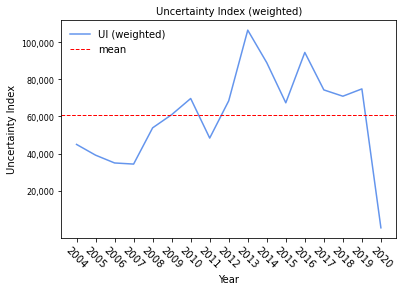

<Figure size 432x288 with 0 Axes>

In [34]:
# Plot index over time ("uncertainty" (and its variant) only)

# Sort dataframe according to year
df_uncertainty_index_time_weighted = df_uncertainty_index_time_weighted.sort_values(by = ['year'], ascending = True)

# Assign plot contents
year = df_uncertainty_index_time_weighted['year']
index_value_rescaled_weighted = df_uncertainty_index_time_weighted['index_value_rescaled_weighted']

index_value_rescaled_weighted_mean = df_uncertainty_index_time_weighted['index_value_rescaled_weighted'].mean()

# Generate plot
fig4 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled_weighted, 'cornflowerblue', label = 'UI (weighted)')
plt.axhline(y = index_value_rescaled_weighted_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.title('Uncertainty Index (weighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Uncertainty Index', fontsize = 10)
plt.yticks([20000, 40000, 60000, 80000, 100000],
           ['20,000', '40,000', '60,000', '80,000', '100,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(loc='upper left', frameon=False)
plt.show()

plt.savefig(output_path + '06_ui_time_weighted.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

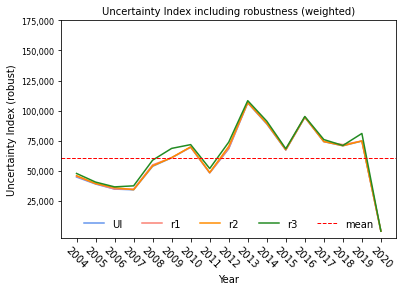

<Figure size 432x288 with 0 Axes>

In [35]:
# Plot index over time (including robustness checks)

# Assign plot contents
index_value_rescaled_weighted = df_uncertainty_index_time_weighted['index_value_rescaled_weighted']
index_value_rescaled_weighted_r1 = df_uncertainty_index_time_weighted['index_value_rescaled_weighted_r1']
index_value_rescaled_weighted_r2 = df_uncertainty_index_time_weighted['index_value_rescaled_weighted_r2']
index_value_rescaled_weighted_r3 = df_uncertainty_index_time_weighted['index_value_rescaled_weighted_r3']

index_value_rescaled_weighted_mean = df_uncertainty_index_time_weighted['index_value_rescaled_weighted'].mean()

# Generate plot
fig5 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled_weighted, 'cornflowerblue', label = 'UI')
plt.plot(year, index_value_rescaled_weighted_r1, 'salmon', label = 'r1')
plt.plot(year, index_value_rescaled_weighted_r2, 'darkorange', label = 'r2')
plt.plot(year, index_value_rescaled_weighted_r3, 'forestgreen', label = 'r3')
plt.axhline(y = index_value_rescaled_weighted_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.title('Uncertainty Index including robustness (weighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Uncertainty Index (robust)', fontsize = 10)
plt.yticks([25000, 50000, 75000, 100000, 125000, 150000, 175000],
           ['25,000', '50,000', '75,000', '100,000', '125,000', '150,000', '175,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='lower center', ncol=5)
plt.show()

plt.savefig(output_path + '07_ui_time_weighted_r.png')

# Optimism index

## Generate set of words

Idea: randomly select number of "other words" that are marked as "most relevant" in the Thesaurus dictionary.

"Optimism" (https://www.thesaurus.com/browse/optimism?s=t)

- anticipation
- certainty
- confidence
- elation
- enthusiasm
- expectation
- happiness
- idealism
- trust

In [36]:
# Randomly select sets of words

# Define list of words from above
optimism_thesaurus = ['anticipation', 'certainty', 'confidence', 'elation', 
                      'enthusiasm', 'expectation', 'happiness', 'idealism', 'trust']

# Set 1: two words
optimism_syn_1 = random.sample(optimism_thesaurus, 2)

# Set 2: two words not in first random set
optimism_thesaurus_d = list((Counter(optimism_thesaurus) 
                             - Counter(optimism_syn_1)).elements())
optimism_syn_2 = random.sample((optimism_thesaurus_d), 2)

# Set 3: five words
optimism_syn_3 = random.sample(optimism_thesaurus, 5)


# Assign drawn words for further use
optimism_syn_1_1_stem = ps.stem(optimism_syn_1[0])
optimism_syn_1_2_stem = ps.stem(optimism_syn_1[1])

optimism_syn_2_1_stem = ps.stem(optimism_syn_2[0])
optimism_syn_2_2_stem = ps.stem(optimism_syn_2[1])

optimism_syn_3_1_stem = ps.stem(optimism_syn_3[0])
optimism_syn_3_2_stem = ps.stem(optimism_syn_3[1])
optimism_syn_3_3_stem = ps.stem(optimism_syn_3[2])
optimism_syn_3_4_stem = ps.stem(optimism_syn_3[3])
optimism_syn_3_5_stem = ps.stem(optimism_syn_3[4])


print("Random samples selected for 'optimism'.")
print("1st random sample:", optimism_syn_1_1_stem, optimism_syn_1_2_stem)
print("2nd random sample:", optimism_syn_2_1_stem, optimism_syn_2_2_stem)
print("3rd random sample:", optimism_syn_3_1_stem, optimism_syn_3_2_stem, 
      optimism_syn_3_3_stem, optimism_syn_3_4_stem, optimism_syn_3_5_stem)

Random samples selected for 'optimism'.
1st random sample: confid elat
2nd random sample: anticip enthusiasm
3rd random sample: expect trust elat happi confid


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Term frequency

In [37]:
# Number of words per report (stop words removed)
df = df[['report_id', 'country', 'year', 'report_text_clean']].copy()

df['report_text_clean_words'] = df['report_text_clean'].str.len()

df.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean,report_text_clean_words
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar...",13458
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis...",27449
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl...",27556
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ...",15589
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ...",17037


In [38]:
# Get stems of variants of "optimism"
print(ps.stem('optimism'))
print(ps.stem('optimistic'))

# print(ps.stem('optimal'))
# print(ps.stem('optimum'))

optim
optimist


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Count stems in every report

# "optimism"
df['no_optim'] = df['report_text_clean'].map(lambda x: x.count("optim"))
df['no_optimist'] = df['report_text_clean'].map(lambda x: x.count("optimist"))

# Random sample 1
df['no_' + str(optimism_syn_1_1_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_1_1_stem))
df['no_' + str(optimism_syn_1_2_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_1_2_stem))

# Random sample 2
df['no_' + str(optimism_syn_2_1_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_2_1_stem))
df['no_' + str(optimism_syn_2_2_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_2_2_stem))

# Random sample 3
df['no_' + str(optimism_syn_3_1_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_3_1_stem))
df['no_' + str(optimism_syn_3_2_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_3_2_stem))
df['no_' + str(optimism_syn_3_3_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_3_3_stem))
df['no_' + str(optimism_syn_3_4_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_3_4_stem))
df['no_' + str(optimism_syn_3_5_stem)] = df['report_text_clean'].map(lambda x: x.count(optimism_syn_3_5_stem))

df.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean,report_text_clean_words,no_optim,no_optimist,no_confid,no_elat,no_anticip,no_enthusiasm,no_expect,no_trust,no_happi
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar...",13458,0,0,0,0,2,0,43,0,0
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis...",27449,0,0,18,0,2,0,31,8,0
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl...",27556,2,4,10,0,1,0,37,0,0
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ...",15589,0,0,2,0,3,0,43,2,0
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ...",17037,0,0,12,0,0,0,63,2,0


In [40]:
# Construct sum of word counts for index

# "optimism" (and its variant) only
df['total_optimism'] = (df['no_optim'] 
                        + df['no_optimist'])


# "optimism" plus random sample 1
df['total_optimism_r1'] = (df['no_optim'] 
                           + df['no_optimist'] 
                           + df['no_' + str(optimism_syn_1_1_stem)] 
                           + df['no_' + str(optimism_syn_1_2_stem)])


# "optimism" plus random sample 2
df['total_optimism_r2'] = (df['no_optim'] 
                           + df['no_optimist'] 
                           + df['no_' + str(optimism_syn_2_1_stem)] 
                           + df['no_' + str(optimism_syn_2_2_stem)])


# "optimism" plus random sample 3
df['total_optimism_r3'] = (df['no_optim'] 
                           + df['no_optimist'] 
                           + df['no_' + str(optimism_syn_3_1_stem)] 
                           + df['no_' + str(optimism_syn_3_2_stem)] 
                           + df['no_' + str(optimism_syn_3_3_stem)] 
                           + df['no_' + str(optimism_syn_3_4_stem)] 
                           + df['no_' + str(optimism_syn_3_5_stem)])

df.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text_clean,report_text_clean_words,no_optim,no_optimist,no_confid,no_elat,no_anticip,no_enthusiasm,no_expect,no_trust,no_happi,total_optimism,total_optimism_r1,total_optimism_r2,total_optimism_r3
402,B_7558,Aruba,2019,"[imf, countri, report, kingdom, netherland, ar...",13458,0,0,0,0,2,0,43,0,0,0,0,2,43
406,B_7787,Afghanistan,2019,"[imf, countri, report, islam, republ, afghanis...",27449,0,0,18,0,2,0,31,8,0,0,18,2,57
423,B_7559,Armenia,2019,"[imf, countri, report, republ, armenia, articl...",27556,2,4,10,0,1,0,37,0,0,6,16,7,53
436,B_7466,Australia,2018,"[imf, countri, report, australia, articl, iv, ...",15589,0,0,2,0,3,0,43,2,0,0,2,3,47
438,B_7872,Australia,2019,"[imf, countri, report, australia, articl, iv, ...",17037,0,0,12,0,0,0,63,2,0,0,12,0,77


## Optimism Index over time (unweighted)

In [41]:
# Generate total number of words in a given year
df_year_words = pd.DataFrame()

df_year_words['words_year'] = df.groupby(['year'])['report_text_clean_words'].sum()
df_year_words = df_year_words.reset_index()

df_year_words

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,words_year
0,2004,1441934
1,2005,1525083
2,2006,1464439
3,2007,1397712
4,2008,1386209
5,2009,1362423
6,2010,1551932
7,2011,1583661
8,2012,1760920
9,2013,1796611


In [42]:
# Generate total number of optimism measures over time

# Generate dataframe
df_year_optimism = pd.DataFrame()

# "optimism" (and its variant) only
df_year_optimism['optimism_year'] = df.groupby(['year'])['total_optimism'].sum()

# "optimism" plus random sample 1
df_year_optimism['optimism_year_r1'] = df.groupby(['year'])['total_optimism_r1'].sum()

# "optimism" plus random sample 2
df_year_optimism['optimism_year_r2'] = df.groupby(['year'])['total_optimism_r2'].sum()

# "optimism" plus random sample 3
df_year_optimism['optimism_year_r3'] = df.groupby(['year'])['total_optimism_r3'].sum()


df_year_optimism = df_year_optimism.reset_index()


df_year_optimism

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,optimism_year,optimism_year_r1,optimism_year_r2,optimism_year_r3
0,2004,132,657,310,3486
1,2005,120,588,341,3448
2,2006,77,562,263,3233
3,2007,89,486,238,3026
4,2008,89,641,266,3637
5,2009,130,824,333,3949
6,2010,206,916,418,4241
7,2011,159,793,351,3947
8,2012,233,950,440,4700
9,2013,247,1030,498,4979


In [43]:
# Combine to index

# Generate dataframe
df_optimism_index_time = pd.DataFrame()

# Add year to dataframe
df_optimism_index_time['year'] = df_year_optimism['year']

# Calculate word frequency as percentage share
df_optimism_index_time['index_value'] = ((df_year_optimism['optimism_year'] 
                                          / df_year_words['words_year']) 
                                         * 100)

df_optimism_index_time['index_value_r1'] = ((df_year_optimism['optimism_year_r1'] 
                                             / df_year_words['words_year']) 
                                            * 100)

df_optimism_index_time['index_value_r2'] = ((df_year_optimism['optimism_year_r2'] 
                                             / df_year_words['words_year']) 
                                            * 100)

df_optimism_index_time['index_value_r3'] = ((df_year_optimism['optimism_year_r3'] 
                                             / df_year_words['words_year']) 
                                            * 100)

# Rescale by multiplying by 1,000,000
df_optimism_index_time['index_value_rescaled'] = df_optimism_index_time['index_value'] * 1000000
df_optimism_index_time['index_value_rescaled_r1'] = df_optimism_index_time['index_value_r1'] * 1000000
df_optimism_index_time['index_value_rescaled_r2'] = df_optimism_index_time['index_value_r2'] * 1000000
df_optimism_index_time['index_value_rescaled_r3'] = df_optimism_index_time['index_value_r3'] * 1000000


df_optimism_index_time

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,index_value,index_value_r1,index_value_r2,index_value_r3,index_value_rescaled,index_value_rescaled_r1,index_value_rescaled_r2,index_value_rescaled_r3
0,2004,0.009154,0.045564,0.021499,0.241759,9154.371837,45563.805278,21498.903556,241758.638051
1,2005,0.007868,0.038555,0.022359,0.226086,7868.424210,38555.278631,22359.438798,226086.055644
2,2006,0.005258,0.038376,0.017959,0.220767,5257.986164,38376.470444,17959.095599,220767.133353
3,2007,0.006368,0.034771,0.017028,0.216497,6367.549252,34771.111645,17027.828337,216496.674565
4,2008,0.006420,0.046241,0.019189,0.262370,6420.388268,46241.223365,19189.025609,262370.248642
5,2009,0.009542,0.060480,0.024442,0.289851,9541.823648,60480.482200,24441.748268,289851.242969
6,2010,0.013274,0.059023,0.026934,0.273272,13273.777459,59023.204625,26934.169796,273272.282548
7,2011,0.010040,0.050074,0.022164,0.249233,10040.027506,50073.847875,22163.834305,249232.632489
8,2012,0.013232,0.053949,0.024987,0.266906,13231.719783,53949.072076,24986.938646,266905.935534
9,2013,0.013748,0.057330,0.027719,0.277133,13748.106852,57330.162178,27718.855111,277132.890759


In [44]:
# Export to csv
df_optimism_index_time.to_csv(output_path + r'04_df_optimism_index_time.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

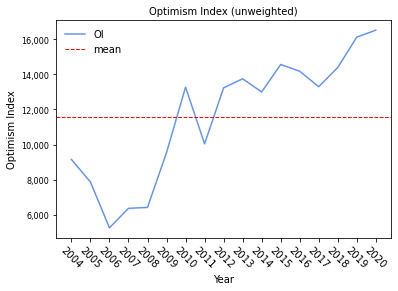

<Figure size 432x288 with 0 Axes>

In [45]:
# Plot optimism index over time ("optimism" (and its variant) only)

# Sort dataframe according to year
df_optimism_index_time = df_optimism_index_time.sort_values(by = ['year'], ascending = True)

# Assign plot contents
year = df_optimism_index_time['year']
index_value_rescaled = df_optimism_index_time['index_value_rescaled']

index_value_rescaled_mean = df_optimism_index_time['index_value_rescaled'].mean()

# Generate plot
fig6 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled, 'cornflowerblue', label = 'OI')
plt.axhline(y = index_value_rescaled_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.title('Optimism Index (unweighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Optimism Index', fontsize = 10)
plt.yticks([6000, 8000, 10000, 12000, 14000, 16000],
           ['6,000', '8,000', '10,000', '12,000', '14,000', '16,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(loc='upper left', frameon=False)
plt.show()

plt.savefig(output_path + '08_oi_time_unweighted.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

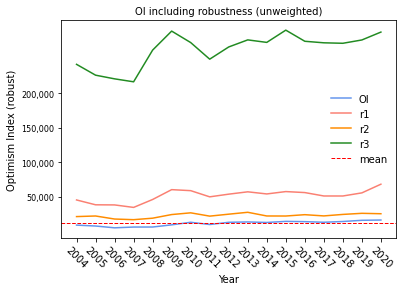

<Figure size 432x288 with 0 Axes>

In [46]:
# Plot index over time (including robustness checks)

# Assign plot contents
index_value_rescaled = df_optimism_index_time['index_value_rescaled']
index_value_rescaled_r1 = df_optimism_index_time['index_value_rescaled_r1']
index_value_rescaled_r2 = df_optimism_index_time['index_value_rescaled_r2']
index_value_rescaled_r3 = df_optimism_index_time['index_value_rescaled_r3']

index_value_rescaled_mean = df_optimism_index_time['index_value_rescaled'].mean()

# Generate plot
fig7 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled, 'cornflowerblue', label = 'OI')
plt.plot(year, index_value_rescaled_r1, 'salmon', label = 'r1')
plt.plot(year, index_value_rescaled_r2, 'darkorange', label = 'r2')
plt.plot(year, index_value_rescaled_r3, 'forestgreen', label = 'r3')
plt.axhline(y = index_value_rescaled_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.title('OI including robustness (unweighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Optimism Index (robust)', fontsize = 10)
plt.yticks([50000, 100000, 150000, 200000],
           ['50,000', '100,000', '150,000', '200,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='center right')
plt.show()

plt.savefig(output_path + '09_oi_time_unweighted_r.png')

## Optimism Index per country

In [47]:
# Generate total number of words for a given country
df_country_words = pd.DataFrame()

df_country_words['words_country'] = df.groupby(['country'])['report_text_clean_words'].sum()
df_country_words = df_country_words.reset_index()

df_country_words.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,words_country
0,Afghanistan,188184
1,Albania,190119
2,Algeria,149847
3,Angola,98133
4,Anguilla,6748


In [48]:
# Generate total number of "optimism" (and its variant) per country
df_country_optimism = pd.DataFrame()

df_country_optimism['optimism_country'] = df.groupby(['country'])['total_optimism'].sum()
df_country_optimism['optimism_country_r3'] = df.groupby(['country'])['total_optimism_r3'].sum()

df_country_optimism = df_country_optimism.reset_index()

df_country_optimism.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,optimism_country,optimism_country_r3
0,Afghanistan,8,527
1,Albania,20,559
2,Algeria,9,265
3,Angola,8,226
4,Anguilla,0,10


In [49]:
# Combine to index

# Generate dataframe
df_optimism_index_country = pd.DataFrame()

# Add country to dataframe
df_optimism_index_country['country'] = df_country_optimism['country']

# Calculate word frequency as percentage share
df_optimism_index_country['index_value'] = (df_country_optimism['optimism_country'] / df_country_words['words_country']) * 100
df_optimism_index_country['index_value_r3'] = (df_country_optimism['optimism_country_r3'] / df_country_words['words_country']) * 100

# Rescale by multiplying by 1,000,000
df_optimism_index_country['index_value_rescaled'] = df_optimism_index_country['index_value'] * 1000000
df_optimism_index_country['index_value_rescaled_r3'] = df_optimism_index_country['index_value_r3'] * 1000000


df_optimism_index_country.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,index_value,index_value_r3,index_value_rescaled,index_value_rescaled_r3
0,Afghanistan,0.004251,0.280045,4251.158441,280045.062279
1,Albania,0.010520,0.294026,10519.727118,294026.372956
2,Algeria,0.006006,0.176847,6006.126249,176847.050658
3,Angola,0.008152,0.230300,8152.201604,230299.695311
4,Anguilla,0.000000,0.148192,0.000000,148192.056906


In [50]:
# Export to csv
df_optimism_index_country.to_csv(output_path + r'05_df_optimism_index_country.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


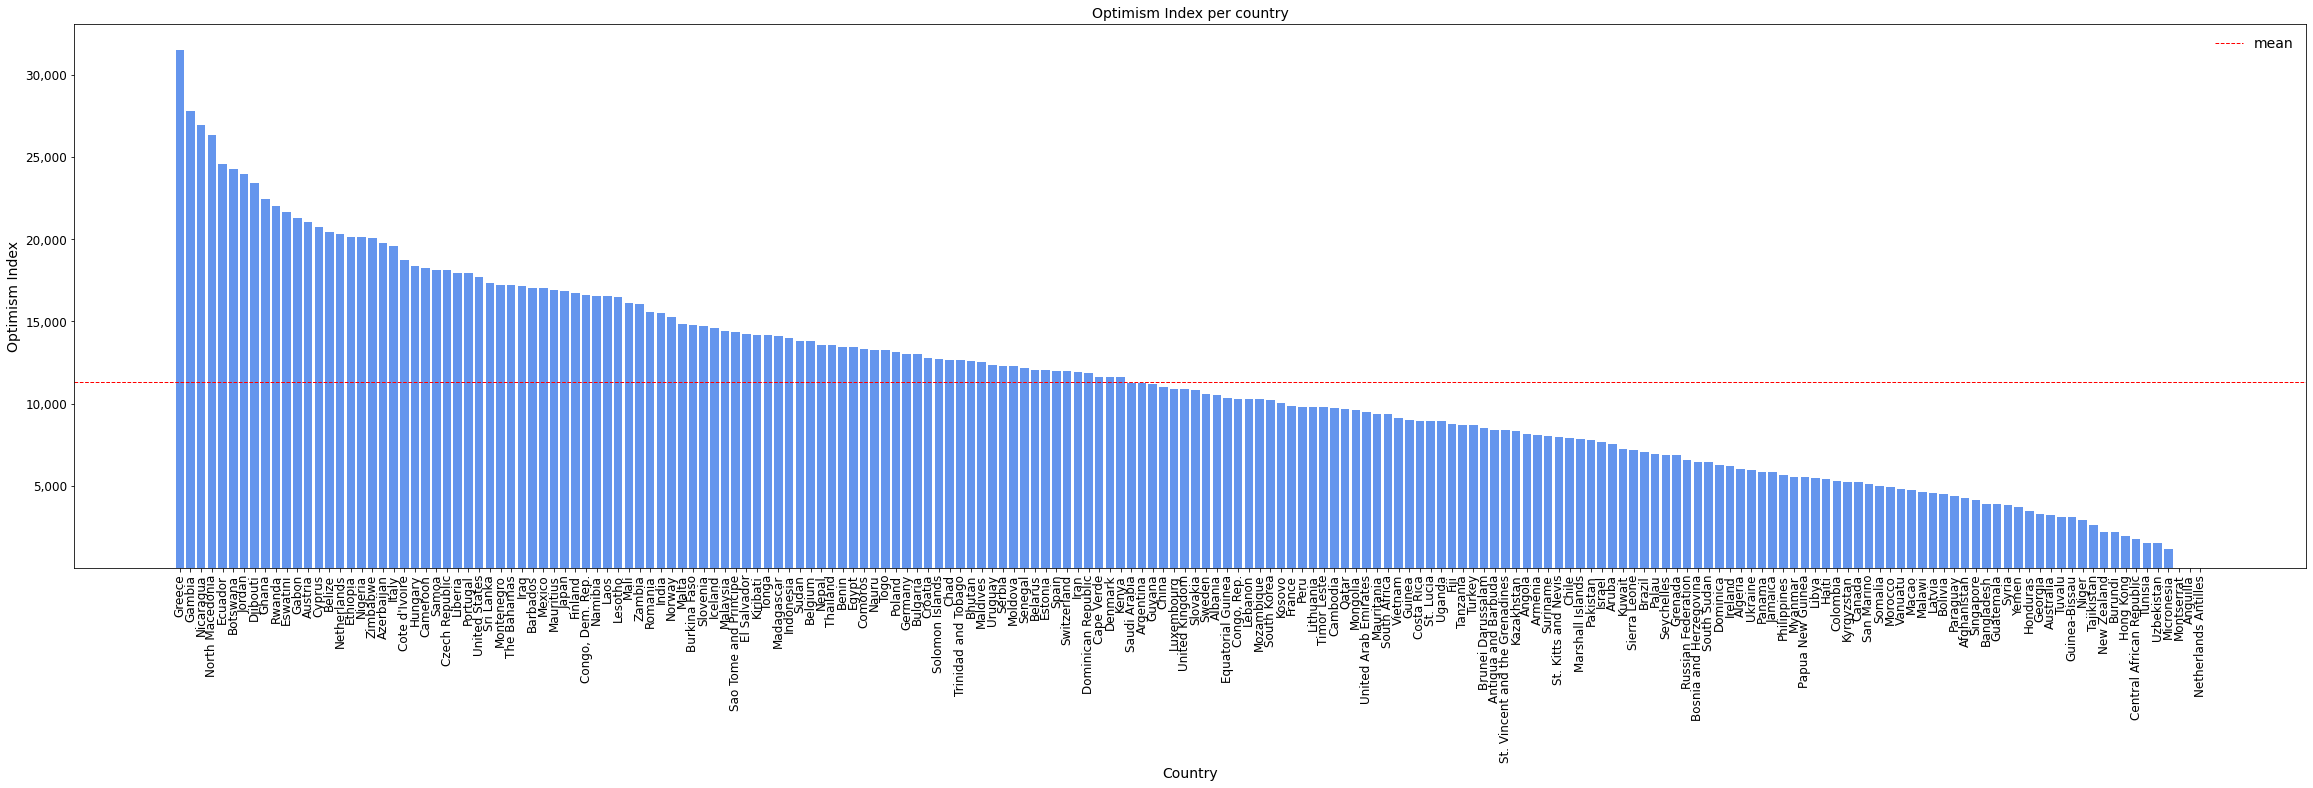

<Figure size 432x288 with 0 Axes>

In [347]:
# Plot index per country ("optimism" (and its variant) only)

# Sort dataframe according to index value
df_optimism_index_country = df_optimism_index_country.sort_values(by = ['index_value_rescaled'], ascending = False)

# Assign plot contents
country = df_optimism_index_country['country']
index_value_rescaled = df_optimism_index_country['index_value_rescaled']
index_value_rescaled_mean = df_optimism_index_country['index_value_rescaled'].mean()

# Generate plot
fig, ax = plt.subplots(figsize=(40,10))
plt.xticks(rotation = 90)
plt.bar(country, index_value_rescaled, color = 'cornflowerblue')
plt.axhline(y = index_value_rescaled_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.xlabel('Country', fontsize = 14)
plt.ylabel('Optimism Index', fontsize = 14)
plt.title('Optimism Index per country', fontsize = 14)
plt.yticks([5000, 10000, 15000, 20000, 25000, 30000],
           ['5,000', '10,000', '15,000', '20,000', '25,000', '30,000'], fontsize = 12)
plt.xticks(fontsize = 12)
leg = ax.legend(loc='upper right', frameon=False, fontsize = 14);
plt.show()

plt.savefig(output_path + '10_oi_country.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


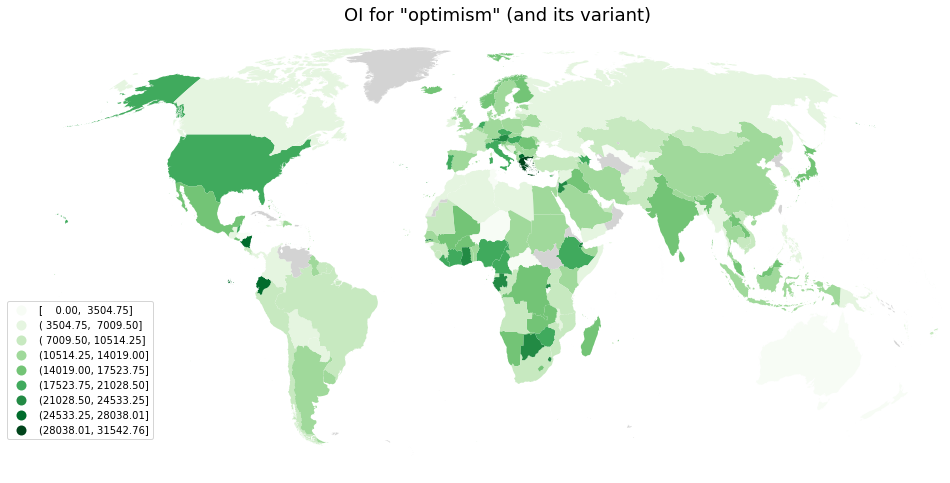

In [52]:
# Plot world map ("optimism" (and its variant) only)
shapefile = os.path.expanduser(input_path + '/shp_countries/ne_10m_admin_0_countries.shp')
isofile = os.path.expanduser(input_path + '/iso_3_codes.csv')

colors = 9
cmap = 'Greens'
figsize = (16, 10)
scheme = 'equal_interval'
title = 'OI for "optimism" (and its variant)'

gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
df_iso = pd.read_csv(isofile)
df_map = df_optimism_index_country

merged = gdf.merge(df_iso, left_on = 'ADM0_A3', right_on = 'country_iso3', how = 'outer')

merged = merged.merge(df_map, left_on = 'country', right_on = 'country', how = 'outer')
merged = merged[merged.ADM0_A3 != 'ATA']

ax = merged.dropna().plot(column = 'index_value_rescaled', cmap = cmap, figsize = figsize, scheme = scheme, k = colors, legend = True)
merged[merged.isna().any(axis = 1)].plot(ax = ax, color = 'lightgrey')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title(title, fontdict = {'fontsize': 12}, loc = 'center')

plt.savefig(output_path + '11_world map_optimism.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


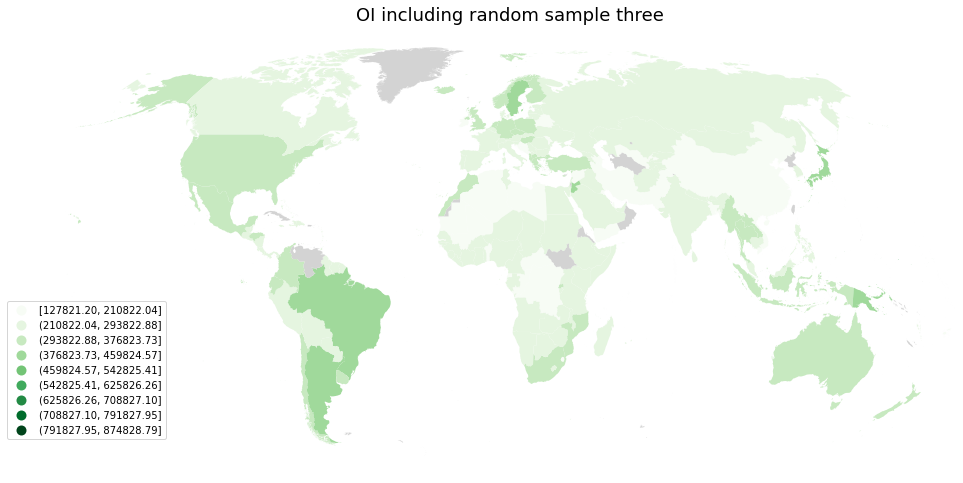

In [53]:
# Plot world map (including random sample three)
shapefile = os.path.expanduser(input_path + '/shp_countries/ne_10m_admin_0_countries.shp')
isofile = os.path.expanduser(input_path + '/iso_3_codes.csv')

colors = 9
cmap = 'Greens'
figsize = (16, 10)
scheme = 'equal_interval'
title = 'OI including random sample three'

gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
df_iso = pd.read_csv(isofile)
df_map = df_optimism_index_country

merged = gdf.merge(df_iso, left_on = 'ADM0_A3', right_on = 'country_iso3', how = 'outer')

merged = merged.merge(df_map, left_on = 'country', right_on = 'country', how = 'outer')
merged = merged[merged.ADM0_A3 != 'ATA']

ax = merged.dropna().plot(column = 'index_value_rescaled_r3', cmap = cmap, figsize = figsize, \
                          scheme = scheme, k = colors, legend = True)

merged[merged.isna().any(axis = 1)].plot(ax = ax, color = 'lightgrey')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title(title, fontdict = {'fontsize': 12}, loc = 'center')

plt.savefig(output_path + '12_world_map_optimism_r3.png')

## Optimism Index over time (weighted by real GDP)

In [54]:
# Generate total number of words in reports per country per year

# Generate dataframe
df_country_year_optimism_1 = pd.DataFrame()

# Generate total number of words per country per year
df_country_year_optimism_1['words_year_country'] = df.groupby(['country', 'year'])['report_text_clean_words'].sum()
df_country_year_optimism_1 = df_country_year_optimism_1.reset_index()


# Generate unique merge ID
df_country_year_optimism_1['year'] = df_country_year_optimism_1['year'].map(str)
df_country_year_optimism_1['country_year_id'] = (df_country_year_optimism_1['country'] 
                                                 + '_' 
                                                 + df_country_year_optimism_1['year'])

df_country_year_optimism_1.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id
0,Afghanistan,2004,15287,Afghanistan_2004
1,Afghanistan,2005,16002,Afghanistan_2005
2,Afghanistan,2007,20880,Afghanistan_2007
3,Afghanistan,2011,32283,Afghanistan_2011
4,Afghanistan,2014,22779,Afghanistan_2014


In [55]:
# Generate total number of optimism measures per country per year

# Generate dataframe
df_country_year_optimism_2 = pd.DataFrame()

# "optimism" (and its variant) only
df_country_year_optimism_2['optimism_year_country'] = df.groupby(['country', 'year'])['total_optimism'].sum()

# "optimism" & random sample 1
df_country_year_optimism_2['optimism_year_country_r1'] = df.groupby(['country', 'year'])['total_optimism_r1'].sum()

# "optimism" & random sample 2
df_country_year_optimism_2['optimism_year_country_r2'] = df.groupby(['country', 'year'])['total_optimism_r2'].sum()

# "optimism" & random sample 3
df_country_year_optimism_2['optimism_year_country_r3'] = df.groupby(['country', 'year'])['total_optimism_r3'].sum()

df_country_year_optimism_2 = df_country_year_optimism_2.reset_index()


# Generate unique merge ID
df_country_year_optimism_2['year'] = df_country_year_optimism_2['year'].map(str)
df_country_year_optimism_2['country_year_id'] = (df_country_year_optimism_2['country'] 
                                                 + '_' 
                                                 + df_country_year_optimism_2['year'])

df_country_year_optimism_2.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,optimism_year_country,optimism_year_country_r1,optimism_year_country_r2,optimism_year_country_r3,country_year_id
0,Afghanistan,2004,0,4,2,61,Afghanistan_2004
1,Afghanistan,2005,0,3,6,54,Afghanistan_2005
2,Afghanistan,2007,2,4,3,54,Afghanistan_2007
3,Afghanistan,2011,5,10,10,80,Afghanistan_2011
4,Afghanistan,2014,0,16,3,49,Afghanistan_2014


In [56]:
# Merge word and stemm frequency frames

# Generate dataframe
df_country_year_optimism = pd.DataFrame()

# Only keep relevant columns for optimism
df_country_year_optimism_2 = (df_country_year_optimism_2[['optimism_year_country', 'optimism_year_country_r1', 
                                                          'optimism_year_country_r2', 'optimism_year_country_r3', 
                                                          'country_year_id']])

# Merge dataframes
df_country_year_optimism = df_country_year_optimism_1.merge(df_country_year_optimism_2, 
                                                            left_on = 'country_year_id', right_on = 'country_year_id')


df_country_year_optimism.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id,optimism_year_country,optimism_year_country_r1,optimism_year_country_r2,optimism_year_country_r3
0,Afghanistan,2004,15287,Afghanistan_2004,0,4,2,61
1,Afghanistan,2005,16002,Afghanistan_2005,0,3,6,54
2,Afghanistan,2007,20880,Afghanistan_2007,2,4,3,54
3,Afghanistan,2011,32283,Afghanistan_2011,5,10,10,80
4,Afghanistan,2014,22779,Afghanistan_2014,0,16,3,49


In [57]:
# Generate index value for every country for every year

# Calculate word frequency as percentage share
df_country_year_optimism['index_value'] = ((df_country_year_optimism['optimism_year_country'] 
                                            / df_country_year_optimism['words_year_country']) 
                                           * 100)

df_country_year_optimism['index_value_r1'] = ((df_country_year_optimism['optimism_year_country_r1'] 
                                               / df_country_year_optimism['words_year_country']) 
                                              * 100)

df_country_year_optimism['index_value_r2'] = ((df_country_year_optimism['optimism_year_country_r2'] 
                                               / df_country_year_optimism['words_year_country']) 
                                              * 100)

df_country_year_optimism['index_value_r3'] = ((df_country_year_optimism['optimism_year_country_r3'] 
                                               / df_country_year_optimism['words_year_country']) 
                                              * 100)

# Rescale by multiplying by 1,000,000
df_country_year_optimism['index_value_rescaled'] = df_country_year_optimism['index_value'] * 1000000
df_country_year_optimism['index_value_rescaled_r1'] = df_country_year_optimism['index_value_r1'] * 1000000
df_country_year_optimism['index_value_rescaled_r2'] = df_country_year_optimism['index_value_r2'] * 1000000
df_country_year_optimism['index_value_rescaled_r3'] = df_country_year_optimism['index_value_r3'] * 1000000


df_country_year_optimism.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id,optimism_year_country,optimism_year_country_r1,optimism_year_country_r2,optimism_year_country_r3,index_value,index_value_r1,index_value_r2,index_value_r3,index_value_rescaled,index_value_rescaled_r1,index_value_rescaled_r2,index_value_rescaled_r3
0,Afghanistan,2004,15287,Afghanistan_2004,0,4,2,61,0.000000,0.026166,0.013083,0.399032,0.000000,26166.023419,13083.011709,399031.857134
1,Afghanistan,2005,16002,Afghanistan_2005,0,3,6,54,0.000000,0.018748,0.037495,0.337458,0.000000,18747.656543,37495.313086,337457.817773
2,Afghanistan,2007,20880,Afghanistan_2007,2,4,3,54,0.009579,0.019157,0.014368,0.258621,9578.544061,19157.088123,14367.816092,258620.689655
3,Afghanistan,2011,32283,Afghanistan_2011,5,10,10,80,0.015488,0.030976,0.030976,0.247808,15488.027755,30976.055509,30976.055509,247808.444073
4,Afghanistan,2014,22779,Afghanistan_2014,0,16,3,49,0.000000,0.070240,0.013170,0.215110,0.000000,70240.133456,13170.025023,215110.408710


In [58]:
# Add GDP data
df_gdp = pd.read_csv(input_path + "03_gdp.csv")
df_gdp = df_gdp[['country_year_id', 'share_r_gdp']]
df_gdp = df_gdp.drop_duplicates()

df_merged_gdp = df_country_year_optimism.merge(df_gdp, left_on = 'country_year_id', right_on = 'country_year_id', how = 'outer')

df_merged_gdp.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,year,words_year_country,country_year_id,optimism_year_country,optimism_year_country_r1,optimism_year_country_r2,optimism_year_country_r3,index_value,index_value_r1,index_value_r2,index_value_r3,index_value_rescaled,index_value_rescaled_r1,index_value_rescaled_r2,index_value_rescaled_r3,share_r_gdp
0,Afghanistan,2004,15287.0,Afghanistan_2004,0.0,4.0,2.0,61.0,0.000000,0.026166,0.013083,0.399032,0.000000,26166.023419,13083.011709,399031.857134,0.000147
1,Afghanistan,2005,16002.0,Afghanistan_2005,0.0,3.0,6.0,54.0,0.000000,0.018748,0.037495,0.337458,0.000000,18747.656543,37495.313086,337457.817773,0.000158
2,Afghanistan,2007,20880.0,Afghanistan_2007,2.0,4.0,3.0,54.0,0.009579,0.019157,0.014368,0.258621,9578.544061,19157.088123,14367.816092,258620.689655,0.000174
3,Afghanistan,2011,32283.0,Afghanistan_2011,5.0,10.0,10.0,80.0,0.015488,0.030976,0.030976,0.247808,15488.027755,30976.055509,30976.055509,247808.444073,0.000233
4,Afghanistan,2014,22779.0,Afghanistan_2014,0.0,16.0,3.0,49.0,0.000000,0.070240,0.013170,0.215110,0.000000,70240.133456,13170.025023,215110.408710,0.000264


In [59]:
# Generate weighted index over time (i.e. aggregate over countries in given year)

# Multiply rescaled index values with share in world real GDP 
df_merged_gdp['index_value_rescaled_multi'] = df_merged_gdp['index_value_rescaled'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_rescaled_multi_r1'] = df_merged_gdp['index_value_rescaled_r1'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_rescaled_multi_r2'] = df_merged_gdp['index_value_rescaled_r2'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_rescaled_multi_r3'] = df_merged_gdp['index_value_rescaled_r3'] * df_merged_gdp['share_r_gdp']

# Aggregate weighted index over time
df_optimism_index_time_weighted = pd.DataFrame()
df_optimism_index_time_weighted['index_value_rescaled_weighted'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi'].sum()
df_optimism_index_time_weighted['index_value_rescaled_weighted_r1'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi_r1'].sum()
df_optimism_index_time_weighted['index_value_rescaled_weighted_r2'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi_r2'].sum()
df_optimism_index_time_weighted['index_value_rescaled_weighted_r3'] = df_merged_gdp.groupby(['year'])['index_value_rescaled_multi_r3'].sum()

df_optimism_index_time_weighted = df_optimism_index_time_weighted.reset_index()


df_optimism_index_time_weighted

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,index_value_rescaled_weighted,index_value_rescaled_weighted_r1,index_value_rescaled_weighted_r2,index_value_rescaled_weighted_r3
0,2004,9016.553971,64240.726677,31978.136576,287017.823466
1,2005,12501.651166,68223.362511,20787.443383,246723.637133
2,2006,6732.406573,32776.774251,18437.683538,226375.383322
3,2007,3909.730602,40067.027404,21928.740065,236368.804509
4,2008,4105.673646,81418.427751,14353.584422,291385.405193
5,2009,9869.885131,83762.673829,18487.333406,222821.695115
6,2010,11297.301864,70796.019234,21092.759041,232909.463207
7,2011,10401.116357,57613.081699,24311.939000,217454.811954
8,2012,8974.585220,53332.368761,23250.862562,239265.124670
9,2013,11584.067936,58267.886369,29502.049293,310616.871164


In [60]:
# Export to csv
df_optimism_index_time_weighted.to_csv(output_path + r'06_df_optimism_index_time_weighted.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

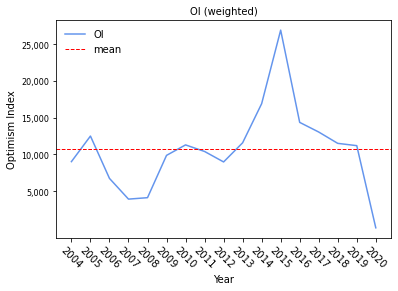

<Figure size 432x288 with 0 Axes>

In [61]:
# Plot index over time ("optimism" (and its variant) only)

# Sort dataframe according to year
df_optimism_index_time_weighted = df_optimism_index_time_weighted.sort_values(by = ['year'], ascending = True)

# Assign plot contents
year = df_optimism_index_time_weighted['year']
index_value_rescaled_weighted = df_optimism_index_time_weighted['index_value_rescaled_weighted']

index_value_rescaled_weighted_mean = df_optimism_index_time_weighted['index_value_rescaled_weighted'].mean()

# Generate plot
fig9 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled_weighted, 'cornflowerblue', label = 'OI')
plt.axhline(y = index_value_rescaled_weighted_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Optimism Index', fontsize = 10)
plt.title('OI (weighted)', fontsize = 10)
plt.yticks([5000, 10000, 15000, 20000, 25000],
           ['5,000', '10,000', '15,000', '20,000', '25,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(loc='upper left', frameon=False)
plt.show()

plt.savefig(output_path + '13_oi_time_weighted.png')

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

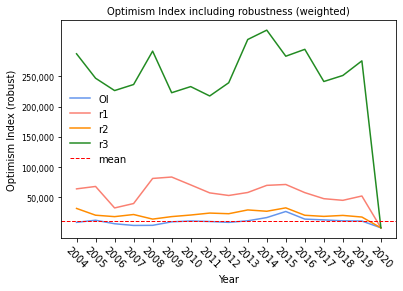

<Figure size 432x288 with 0 Axes>

In [62]:
# Plot index over time (including robustness checks)

# Assign plot contents
index_value_rescaled_weighted = df_optimism_index_time_weighted['index_value_rescaled_weighted']
index_value_rescaled_weighted_r1 = df_optimism_index_time_weighted['index_value_rescaled_weighted_r1']
index_value_rescaled_weighted_r2 = df_optimism_index_time_weighted['index_value_rescaled_weighted_r2']
index_value_rescaled_weighted_r3 = df_optimism_index_time_weighted['index_value_rescaled_weighted_r3']

index_value_rescaled_weighted_mean = df_optimism_index_time_weighted['index_value_rescaled_weighted'].mean()

# Generate plot
fig10 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, index_value_rescaled_weighted, 'cornflowerblue', label = 'OI')
plt.plot(year, index_value_rescaled_weighted_r1, 'salmon', label = 'r1')
plt.plot(year, index_value_rescaled_weighted_r2, 'darkorange', label = 'r2')
plt.plot(year, index_value_rescaled_weighted_r3, 'forestgreen', label = 'r3')
plt.axhline(y = index_value_rescaled_weighted_mean,linewidth = 1, color = 'red', linestyle = '--', label = 'mean')
plt.title('Optimism Index including robustness (weighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Optimism Index (robust)', fontsize = 10)
plt.yticks([50000, 100000, 150000, 200000, 250000],
           ['50,000', '100,000', '150,000', '200,000', '250,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='center left')
plt.show()

plt.savefig(output_path + '14_oi_time_weighted_r.png')

# Comparing Indices

## Optimism index vs. uncertainty index

In [65]:
# Optimism index vs. uncertainty index (unweighted)

# Generate dataframe
df_index_comparison = pd.DataFrame()

# Add (unweighted) optimism index values to dataframe
df_index_comparison['year'] = df_optimism_index_time['year']
df_index_comparison['optimism_unweighted'] = df_optimism_index_time['index_value_rescaled']

# Add (unweighted) uncertainty index values to dataframe
df_uncertainty_index_time = df_uncertainty_index_time[['year', 'index_value_rescaled']]


df_uncertainty_index_time['year'] = df_uncertainty_index_time['year'].astype(int)
df_index_comparison['year'] = df_index_comparison['year'].astype(int)

print(df_uncertainty_index_time['year'].dtype)
print(df_index_comparison['year'].dtype)
#########

df_index_comparison = df_index_comparison.merge(df_uncertainty_index_time, on = 'year')
df_index_comparison = df_index_comparison.rename(columns = {"index_value_rescaled": "uncertainty_unweighted"})

df_index_comparison

int64
int64


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,optimism_unweighted,uncertainty_unweighted
0,2004,9154.371837,31416.139712
1,2005,7868.424210,27736.195341
2,2006,5257.986164,26016.788682
3,2007,6367.549252,25327.106013
4,2008,6420.388268,35997.457815
5,2009,9541.823648,48076.111457
6,2010,13273.777459,44654.018346
7,2011,10040.027506,43380.496205
8,2012,13231.719783,43272.834655
9,2013,13748.106852,55103.748112


In [66]:
# Export to csv
df_index_comparison.to_csv(output_path + r'07_df_index_comparison.csv', index = False)

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

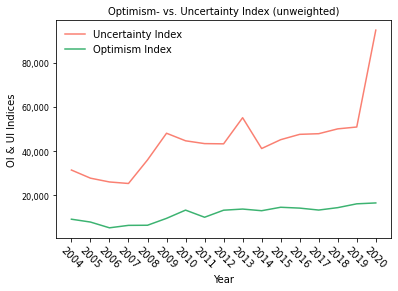

<Figure size 432x288 with 0 Axes>

In [67]:
# Generate plot
fig10 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, df_index_comparison['uncertainty_unweighted'], 'salmon', label = 'Uncertainty Index')
plt.plot(year, df_index_comparison['optimism_unweighted'], 'mediumseagreen', label = 'Optimism Index')
plt.title('Optimism- vs. Uncertainty Index (unweighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('OI & UI Indices', fontsize = 10)
plt.yticks([20000, 40000, 60000, 80000],
           ['20,000', '40,000', '60,000', '80,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='upper left')
plt.show()
plt.savefig(output_path + '15_oi_unweighted_vs_ui_unweighted.png')

In [68]:
# Calculate correlation (returns: Pearson's correlation coefficient, 2-tailed p-value)
pearsonr(df_index_comparison['optimism_unweighted'], df_index_comparison['uncertainty_unweighted'])

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.7475715641940613, 0.0005609027015032614)

In [69]:
# Optimism index vs. uncertainty index (weighted)

# Add (weighted) optimism index values to dataframe
df_optimism_index_time_weighted = df_optimism_index_time_weighted[['year', 'index_value_rescaled_weighted']]
df_optimism_index_time_weighted['year'] = df_optimism_index_time_weighted['year'].astype(int)

#############
df_optimism_index_time['year'] = df_optimism_index_time['year'].astype(int)
###############

df_index_comparison = df_index_comparison.merge(df_optimism_index_time_weighted, on = 'year')
df_index_comparison = df_index_comparison.rename(columns = {"index_value_rescaled_weighted": "optimism_weighted"})

# Add (weighted) uncertainty index values to dataframe
df_uncertainty_index_time_weighted = df_uncertainty_index_time_weighted[['year', 'index_value_rescaled_weighted']]
df_uncertainty_index_time_weighted['year'] = df_uncertainty_index_time_weighted['year'].astype(int)

df_index_comparison = df_index_comparison.merge(df_uncertainty_index_time_weighted, on = 'year')
df_index_comparison = df_index_comparison.rename(columns = {"index_value_rescaled_weighted": "uncertainty_weighted"})

df_index_comparison

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,optimism_unweighted,uncertainty_unweighted,optimism_weighted,uncertainty_weighted
0,2004,9154.371837,31416.139712,9016.553971,44902.084078
1,2005,7868.424210,27736.195341,12501.651166,39113.635115
2,2006,5257.986164,26016.788682,6732.406573,34915.574840
3,2007,6367.549252,25327.106013,3909.730602,34315.154369
4,2008,6420.388268,35997.457815,4105.673646,53827.254922
5,2009,9541.823648,48076.111457,9869.885131,60914.557483
6,2010,13273.777459,44654.018346,11297.301864,69626.304821
7,2011,10040.027506,43380.496205,10401.116357,48318.025420
8,2012,13231.719783,43272.834655,8974.585220,68387.493873
9,2013,13748.106852,55103.748112,11584.067936,106424.545663


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

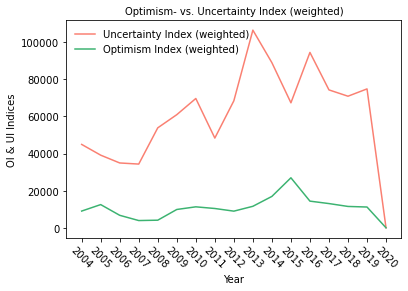

<Figure size 432x288 with 0 Axes>

In [70]:
# Generate plot
fig10 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, df_index_comparison['uncertainty_weighted'], 'salmon', label = 'Uncertainty Index (weighted)')
plt.plot(year, df_index_comparison['optimism_weighted'], 'mediumseagreen', label = 'Optimism Index (weighted)')
plt.title('Optimism- vs. Uncertainty Index (weighted)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('OI & UI Indices', fontsize = 10)
#plt.yticks([20000, 40000, 60000, 80000],
           #['20,000', '40,000', '60,000', '80,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='upper left')
plt.show()
plt.savefig(output_path + '16_oi_weighted_vs_ui_weighted.png')

In [71]:
# Calculate correlation
pearsonr(df_index_comparison['optimism_weighted'], df_index_comparison['uncertainty_weighted'])

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.5987880566119136, 0.011093538375629272)

## Uncertainty index vs. WUI

In [72]:
# Import .csv-file for WUI
df_wui = pd.read_csv(input_path + "wui.csv")

df_wui = df_wui.rename(columns = {"wui_value_a": "wui"})

#df_wui

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# Add WUI values to dataframe
df_index_comparison = df_index_comparison.merge(df_wui, on = 'year')

df_index_comparison = df_index_comparison.sort_values(by = ['year'], ascending = True)

df_index_comparison.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,optimism_unweighted,uncertainty_unweighted,optimism_weighted,uncertainty_weighted,wui
0,2004,9154.371837,31416.139712,9016.553971,44902.084078,13424.547
1,2005,7868.424210,27736.195341,12501.651166,39113.635115,13941.061
2,2006,5257.986164,26016.788682,6732.406573,34915.574840,10173.527
3,2007,6367.549252,25327.106013,3909.730602,34315.154369,16882.127
4,2008,6420.388268,35997.457815,4105.673646,53827.254922,14622.373


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

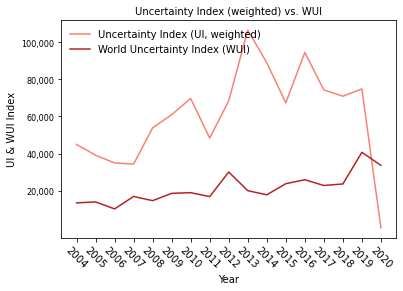

<Figure size 432x288 with 0 Axes>

In [74]:
# Generate plot
fig11 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, df_index_comparison['uncertainty_weighted'], 'salmon', label = 'Uncertainty Index (UI, weighted)')
plt.plot(year, df_index_comparison['wui'], 'firebrick', label = 'World Uncertainty Index (WUI)')
plt.title('Uncertainty Index (weighted) vs. WUI', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('UI & WUI Index', fontsize = 10)
plt.yticks([20000, 40000, 60000, 80000, 100000],
           ['20,000', '40,000', '60,000', '80,000', '100,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='upper left')
plt.show()

plt.savefig(output_path + '17_ui_weighted_vs_wui.png')

In [75]:
# Calculate correlation
pearsonr(df_index_comparison['uncertainty_weighted'], df_index_comparison['wui'])

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.12793795457561336, 0.6246001584031623)

## Optimism index vs. WUI

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

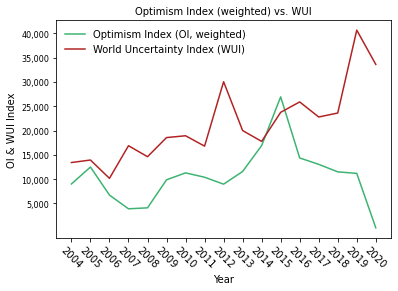

<Figure size 432x288 with 0 Axes>

In [76]:
# Generate plot
fig12 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, df_index_comparison['optimism_weighted'], 'mediumseagreen', label = 'Optimism Index (OI, weighted)')
plt.plot(year, df_index_comparison['wui'], 'firebrick', label = 'World Uncertainty Index (WUI)')
plt.title('Optimism Index (weighted) vs. WUI', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('OI & WUI Index', fontsize = 10)
plt.yticks([5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000],
           ['5,000', '10,000', '15,000', '20,000', '25,000', '30,000', '35,000', '40,000'], fontsize = 8)
plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='upper left')
plt.show()
plt.savefig(output_path + '18_oi_weighted_vs_wui.png')

In [77]:
# Calculate correlation
pearsonr(df_index_comparison['optimism_weighted'], df_index_comparison['wui'])

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.029884280093556204, 0.9093525371043426)

## Uncertainty index (US) vs. VIX
- The VIX only covers the US as it its based on S&P 500 index options 
(https://www.cboe.com/tradable_products/vix/vix_options/?gclsrc=ds)

In [319]:
# Get Uncertainty Index value for US over time

df_country_year_uncertainty_vix = df_country_year_uncertainty[['country', 'year', 'index_value_rescaled']]

# Extract Uncertainty Index values for US
df_country_year_uncertainty_vix = df_country_year_uncertainty_vix[df_country_year_uncertainty_vix.country == 'United States']

# Rename the Index value column to uncertainty_us
df_country_year_uncertainty_vix = df_country_year_uncertainty_vix.rename(columns = {"index_value_rescaled": "uncertainty_us"})

# Only keep our variables of interest, year and uncertainty_us
df_country_year_uncertainty_vix = df_country_year_uncertainty_vix[['year', 'uncertainty_us']].reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
df_country_year_uncertainty_vix = df_country_year_uncertainty_vix[['year', 'uncertainty_us']]
df_country_year_uncertainty_vix

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,uncertainty_us
0,2004,52258.305338
1,2005,48563.334682
2,2006,44203.081586
3,2007,47132.757266
4,2008,56967.884355
5,2009,81900.081900
6,2010,147807.521761
7,2011,50350.882714
8,2012,146009.085010
9,2013,71712.627942


In [320]:
# Import .csv-file for VIX
df_vix = pd.read_csv(input_path + "vix.csv")

df_vix = df_vix.rename(columns = {"vix_value_a": "vix"})

df_vix.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,vix
0,2004,15.480357
1,2005,12.807063
2,2006,12.806534
3,2007,17.535936
4,2008,32.692608


In [321]:
# Add VIX values to dataframe
df_country_year_uncertainty_vix['vix'] = df_vix['vix'].values

#df_country_year_uncertainty_vix.reset_index(drop=True)

#print(df_country_year_uncertainty_vix.dtypes)
df_country_year_uncertainty_vix

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,uncertainty_us,vix
0,2004,52258.305338,15.480357
1,2005,48563.334682,12.807063
2,2006,44203.081586,12.806534
3,2007,47132.757266,17.535936
4,2008,56967.884355,32.692608
5,2009,81900.081900,31.478571
6,2010,147807.521761,22.548889
7,2011,50350.882714,24.202579
8,2012,146009.085010,17.798880
9,2013,71712.627942,14.230119


In [322]:
df_country_year_uncertainty_vix['uncertainty_us_normal'] = ((df_country_year_uncertainty_vix['uncertainty_us'] 
                                                             / df_country_year_uncertainty_vix['uncertainty_us'].iloc[0])
                                                              * 100)
                                                           
df_country_year_uncertainty_vix['vix_normal'] = ((df_country_year_uncertainty_vix['vix']
                                                  / df_country_year_uncertainty_vix['vix'].iloc[0])
                                                 *100)

df_country_year_uncertainty_vix

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,uncertainty_us,vix,uncertainty_us_normal,vix_normal
0,2004,52258.305338,15.480357,100.000000,100.000000
1,2005,48563.334682,12.807063,92.929410,82.731057
2,2006,44203.081586,12.806534,84.585754,82.727640
3,2007,47132.757266,17.535936,90.191898,113.278628
4,2008,56967.884355,32.692608,109.012116,211.187688
5,2009,81900.081900,31.478571,156.721657,203.345252
6,2010,147807.521761,22.548889,282.840251,145.661298
7,2011,50350.882714,24.202579,96.350011,156.343804
8,2012,146009.085010,17.798880,279.398813,114.977193
9,2013,71712.627942,14.230119,137.227236,91.923713


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


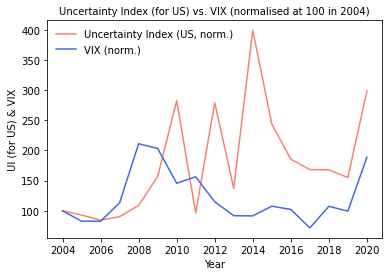

<Figure size 432x288 with 0 Axes>

In [330]:
# Generate plot
fig, ax = plt.subplots()
plt.plot(year, df_country_year_uncertainty_vix['uncertainty_us_normal'], 'salmon', label = 'Uncertainty Index (US, norm.)')
plt.plot(year, (df_country_year_uncertainty_vix['vix_normal']), 'royalblue', label = 'VIX (norm.)')
plt.title('Uncertainty Index (for US) vs. VIX (normalised at 100 in 2004)', fontsize = 10)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('UI (for US) & VIX', fontsize = 10)
#plt.yticks([50000, 100000, 150000, 200000],
           #['50,000', '100,000', '150,000', '200,000'], fontsize = 8)
#plt.xticks(rotation=-45)
leg = ax.legend(frameon=False, loc='upper left')
plt.show()
plt.savefig(output_path + '19_uncertainty_us_vs_vix.png')

In [ ]:
# Calculate correlation
#pearsonr(df_country_year_uncertainty_vix['uncertainty_us'], df_country_year_uncertainty_vix['vix_x'])

# Spillovers

**What did we do?**

(i) **Data preparation**
- tokenize text with keywords as single tokens
- remove stop words
- search tokens for keyword and return tokens before and after in a combined string
- stem tokens

(ii) **Search for 'uncertainty' and 'optimism' in proximity to keywords from spillover countries**
- search for occurrence of 'uncertainty' (or 'optimism' and randomised related stems) in tokens around keywords
- group reports by year and sum up the number of uncertainty- and optimism occurences for every keyword country

(iii) **Calculate spillovers per year (for every keyword country)**
- create yearly spillovers by dividing the uncertainty- and optimism occurences found in the neighbourhood of <br> the keywords by the total number of occurences across all reports in one year, respectively.
- as a result, get spillovers as a share of global uncertainty.


## Data & Keywords List

- Since the lists of keywords from the IMF include keywords with more than one token, we cannot use the cleaned (and thus tokenized) data from previous sections.

In [146]:
# USE IF CLEANED CSV ALREADY EXISTS -> CONTINUE WITH SPILLOVER US
# Import from csv
#print("Data is importing...")
#df_text = pd.read_csv(input_path + r'spillovers_df_text.csv', encoding = "ISO-8859-1", index_col=False)
#print("Data successfully imported.")

# create keywords data frame
#us = ['alan greenspan', 'america', 'barack obama', 'ben bernanke', 'bill clinton', 'donald trump', 'federal reserve', 'george h w bush', 'janet yellen', 'jerome powell', 'nafta', 'north america', 'united states']
#cn = ['china', 'dai xianglong', 'hu jintao', 'jiang zemin', "peoples bank of china", 'xi jinping', 'yi gang', 'zhou xiaochuan']
#uk = ['andrew bailey', 'bank of england', 'boris johnson', 'brexit', 'britain', 'david cameron', 'edward george', 'gordon brown', 'john major', 'mark carney', 'mervin king', 'theresa may', 'tony blair', 'united kingdom', 'great britain']
#ca = ['canada', 'bank of canada', 'david a dodge', 'gordon thiessen', 'jean chrétien', 'justin trudeau', 'mark carney', 'paul martin', 'stephen harper', 'stephen s poloz', 'tiff macklem']
#fr = ['banque de france', 'christian noyer', 'emmanuel macron', 'france', 'françois hollande', 'françois villeroy de galhau', 'jacques chirac', 'jeanclaude trichet', 'nicolas sarkozy']
#de = ['germany', 'bundesbank', 'jens weidmann', 'axel a weber', 'ernst welteke', 'hans tietmeyer', 'helmut kohl', 'gerhard schröder', 'angela merkel']
#it = ['antonio fazio', 'bank of italy', 'enrico letta', 'giuliano amato', 'ignazio visco', 'italy', 'lamberto dini', 'mario draghi', 'mario monti', 'massimo dalema', 'matteo renzi', 'paolo gentiloni', 'romano prodi', 'silvio berlusconi']
#ja = ['bank of japan', 'haruhiko kuroda', 'japan', 'junichirō koizumi', 'keizō obuchi', 'masaaki shirakawa', 'masaru hayami', 'naoto kan', 'ryūtarō hashimoto', 'shinzō abe', 'tarō asō', 'toshihiko fukui', 'yasuo fukuda', 'yasuo matsushita', 'yoshihiko noda', 'yoshirō mori', 'yukio hatoyama']


#df_keywords = pd.DataFrame({'us': [us], 'cn': [cn], 'uk': [uk], 'ca': [ca], 'fr': [fr], 'de': [de], 'it': [it], 'ja': [ja]})

#print("Shape Text Data:", df_text.shape)
#print("Shape Keywords List:", df_keywords.shape)

# define a function that calls one list
#def keywords_list(data, country):
    #country_keywords = str(country)
    #for i in range(data.shape[0]):
        #keywords_list = data.iloc[i][country_keywords]
        #return keywords_list

#print("List of US keywords:", keywords_list(df_keywords, 'us'))

#ps = PorterStemmer()
#def stem_words(words):
    #stemmed_tokens = [ps.stem(word) for word in words]
    #return stemmed_tokens

#df_text.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data is importing...
Data successfully imported.
Shape Text Data: (1844, 13)
Shape Keywords List: (1, 8)
List of US keywords: ['alan greenspan', 'america', 'barack obama', 'ben bernanke', 'bill clinton', 'donald trump', 'federal reserve', 'george h w bush', 'janet yellen', 'jerome powell', 'nafta', 'north america', 'united states']


,report_id,country,year,report_text,report_text_clean,text_token_stop_us,text_token_stop_cn,text_token_stop_uk,text_token_stop_ca,text_token_stop_fr,text_token_stop_de,text_token_stop_it,text_token_stop_ja
0,B_7558,Aruba,2019,...,IMF Country Report No KINGDOM OF THE NETHERLAN...,"['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe..."
1,B_7787,Afghanistan,2019,...,IMF Country Report No ISLAMIC REPUBLIC OF AFGH...,"['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub..."
2,B_7559,Armenia,2019,...,IMF Country Report No REPUBLIC OF ARMENIA ARTI...,"['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme..."
3,B_7466,Australia,2018,...,IMF Country Report No AUSTRALIA ARTICLE IV CON...,"['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art..."
4,B_7872,Australia,2019,...,IMF Country Report No AUSTRALIA ARTICLE IV CON...,"['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art..."


In [ ]:
# Import CSV file
df_text = pd.read_csv(input_path + "01_reports_long.csv", encoding = "ISO-8859-1", index_col=False)
#df_text = pd.read_csv(input_path + "02_reports_short.csv", encoding = "ISO-8859-1", index_col=False)

# Prepare sample
print("Full sample:", df_text.shape)

# keep only 
df_nlp = df_text.loc[df_text['use_nlp'] == 1]
print("Shape w/ NaN:", df_nlp.shape)

# Article IV reports
df_nlp_iv = df_nlp.loc[df_text['article_four'] == 1]
print("Shape w/ NaN, IV:", df_nlp_iv.shape)

# drop missing values in report_text
df_nlp_iv_nan = df_nlp_iv.dropna(subset=['report_text'])
print("Shape w/o NaN, IV:", df_nlp_iv_nan.shape)

# rename dataframe 
df_text = df_nlp_iv_nan

# keep columns
df_text = df_text[['report_id', 'country', 'year', 'report_text']].copy()
print("Shape final sample:", df_text.shape)

df_text.head()

In [ ]:
# create keywords data frame
us = ['alan greenspan', 'america', 'barack obama', 'ben bernanke', 'bill clinton', 'donald trump', 'federal reserve', 'george h w bush', 'janet yellen', 'jerome powell', 'nafta', 'north america', 'united states']
cn = ['china', 'dai xianglong', 'hu jintao', 'jiang zemin', "peoples bank of china", 'xi jinping', 'yi gang', 'zhou xiaochuan']
uk = ['andrew bailey', 'bank of england', 'boris johnson', 'brexit', 'britain', 'david cameron', 'edward george', 'gordon brown', 'john major', 'mark carney', 'mervin king', 'theresa may', 'tony blair', 'united kingdom', 'great britain']
ca = ['canada', 'bank of canada', 'david a dodge', 'gordon thiessen', 'jean chrétien', 'justin trudeau', 'mark carney', 'paul martin', 'stephen harper', 'stephen s poloz', 'tiff macklem']
fr = ['banque de france', 'christian noyer', 'emmanuel macron', 'france', 'françois hollande', 'françois villeroy de galhau', 'jacques chirac', 'jeanclaude trichet', 'nicolas sarkozy']
de = ['germany', 'bundesbank', 'jens weidmann', 'axel a weber', 'ernst welteke', 'hans tietmeyer', 'helmut kohl', 'gerhard schröder', 'angela merkel']
it = ['antonio fazio', 'bank of italy', 'enrico letta', 'giuliano amato', 'ignazio visco', 'italy', 'lamberto dini', 'mario draghi', 'mario monti', 'massimo dalema', 'matteo renzi', 'paolo gentiloni', 'romano prodi', 'silvio berlusconi']
ja = ['bank of japan', 'haruhiko kuroda', 'japan', 'junichirō koizumi', 'keizō obuchi', 'masaaki shirakawa', 'masaru hayami', 'naoto kan', 'ryūtarō hashimoto', 'shinzō abe', 'tarō asō', 'toshihiko fukui', 'yasuo fukuda', 'yasuo matsushita', 'yoshihiko noda', 'yoshirō mori', 'yukio hatoyama']


df_keywords = pd.DataFrame({'us': [us], 'cn': [cn], 'uk': [uk], 'ca': [ca], 'fr': [fr], 'de': [de], 'it': [it], 'ja': [ja]})

print("Shape Text Data:", df_text.shape)
print("Shape Keywords List:", df_keywords.shape)
df_text.head()

In [ ]:
# define a function that calls one list
def keywords_list(data, country):
    country_keywords = str(country)
    for i in range(data.shape[0]):
        keywords_list = data.iloc[i][country_keywords]
        return keywords_list

print("List of US keywords:", keywords_list(df_keywords, 'us'))

## Cleaning

In [ ]:
def clean_text(text):
    text_nonum = re.sub(r'\d+', '', str(text)) # removes numbers
    text_nopunct = re.sub(r'[^\w\s]','', text_nonum) # removes punctuation
    text_line = text_nopunct.strip().replace('\n', ' ') # removes line spacing
    text_apostr = text_line.strip().replace('ÃÂÂ', ' ') # removes unidentified apostrophes
    text_nodoublespace = re.sub(r'\s+', ' ', text_apostr).strip()  # removes all spaces but single spaces
    return text_nodoublespace

df_text['report_text_clean'] = df_text['report_text'].apply(lambda x: clean_text(x))

df_text.report_text_clean.head()

In [ ]:
# tokenize w/o splitting keywords
def tokenize(text):
    text_token = re.findall(pattern, text.lower())
    return(text_token)

# get tokens while keywords count as single token
for i in df_keywords.columns:
    keywords = keywords_list(df_keywords, i)
    pattern = "" # creating the regex pattern
    for keyword in keywords:
        pattern_string = r"\b" + str(keyword) + r"\b|"
        pattern = pattern + pattern_string
    pattern = pattern + r"\S+"
    df_text['text_token_%s' % i] = df_text['report_text_clean'].apply(lambda x: tokenize(x))
    
df_text = df_text.drop(columns = "report_text")
df_text = df_text.drop(columns = "report_text_clean")

df_text.head()

In [ ]:
# Remove stop words
# nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

for i in df_keywords.columns:
    df_text['text_token_stop_%s' % i] = df_text['text_token_%s' % i].apply(lambda x: remove_stopwords(x))

df_text.head()

In [ ]:
# drop text columns with stopwords

for i in df_keywords.columns:
    col = 'text_token_%s' % i
    df_text = df_text.drop(columns = col)

df_text.head()

In [ ]:
ps = PorterStemmer()
def stem_words(words):
    stemmed_tokens = [ps.stem(word) for word in words]
    return stemmed_tokens

In [ ]:
# Export to csv
#df_text.to_csv(input_path + r'spillovers_df_text.csv', index = False)

## Generate Spillovers

In [147]:
#spillovers

# dataframe country name + name short
countries = ['us', 'cn', 'uk', 'ca', 'fr', 'de', 'it', 'ja']
c_name = ['United States', 'China', 'United Kingdom', 'Canada', 'France', 'Germany', 'Italy', 'Japan']
df_country_names = pd.DataFrame({'country_short': countries, 'country_name': c_name})

# get list of indices where x == y
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

df_spill = df_text.copy()

# loop for each keyword country
for country in countries: 
    # neighboring token cell as missing value if report country == keyword country  
    long_name = df_country_names.country_name.values[(df_country_names.country_short.values == country).argmax()] 
    mask = df_spill['country'].str.contains(long_name) # TRUE where report country == keyword country  
    df_spill.loc[mask, 'text_token_stop_%s' % country] = str([]) # replace string with [] where report country == keyword country 
    
    keywords = keywords_list(df_keywords, country) # calls keywords for keyword country
    neigh_tokens = [] # creates empty list for neighboring tokens
    text_col = df_spill['text_token_stop_%s' % country] # calls for keyword country cleaned tokens 

    # for every report
    for report in text_col: 
        neigh_tokens_report = []
        # split string into its tokens
        report = report[1:len(report)-2].replace(' ', '').replace('\'', '').split(",") 
        # for every keyword in the list of keywords
        for j in keywords:
            # get indices list of a specific keyword in a report
            keywords_indices = get_indexes(j,report) 

            # for every keyword occurence in list of keyword indices in a report    
            for g in keywords_indices:
                    # extract the two words before and after the keyword
                    first_index = g-2
                    second_index = g-1
                    third_index = g+1
                    fourth_index = g+2

                    if first_index + g >= 0:
                        # and store them into an empty list
                        neigh_tokens_report.append(report[first_index])

                    if second_index + g >= 0:
                        neigh_tokens_report.append(report[second_index])

                    if len(report) - third_index > 0:
                        neigh_tokens_report.append(report[third_index])

                    if len(report) - fourth_index > 0:
                        neigh_tokens_report.append(report[fourth_index])
        # append all neighboring tokens for a report to a list
        neigh_tokens.append(neigh_tokens_report)
        del neigh_tokens_report
    # neigboring tokens for every report in a new col for keyword country 
    df_spill['neigh_tokens_%s' % country] = neigh_tokens
    
df_spill.head()

# (Check, for example, for Canada that we do not collect keyword neighbourhood tokens 
# for the respective keyword countries themselves:)

#df_spill[df_spill.country.str.contains('Canada')]

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,report_text,report_text_clean,text_token_stop_us,text_token_stop_cn,text_token_stop_uk,text_token_stop_ca,text_token_stop_fr,...,text_token_stop_it,text_token_stop_ja,neigh_tokens_us,neigh_tokens_cn,neigh_tokens_uk,neigh_tokens_ca,neigh_tokens_fr,neigh_tokens_de,neigh_tokens_it,neigh_tokens_ja
0,B_7558,Aruba,2019,...,IMF Country Report No KINGDOM OF THE NETHERLAN...,"['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...",...,"['imf', 'country', 'report', 'kingdom', 'nethe...","['imf', 'country', 'report', 'kingdom', 'nethe...","[countries, south, time, authorities]",[],[],[],[],[],[],[]
1,B_7787,Afghanistan,2019,...,IMF Country Report No ISLAMIC REPUBLIC OF AFGH...,"['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...",...,"['imf', 'country', 'report', 'islamic', 'repub...","['imf', 'country', 'report', 'islamic', 'repub...",[],"[competitiveness, domestic, external, current,...",[],[],[],"[saudi, arabia, tajikistan, germany, germany, ...",[],[]
2,B_7559,Armenia,2019,...,IMF Country Report No REPUBLIC OF ARMENIA ARTI...,"['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...",...,"['imf', 'country', 'report', 'republic', 'arme...","['imf', 'country', 'report', 'republic', 'arme...","[europe, latin, andor, middle]","[lead, economic, iran, also, us, europe, produ...","[countries, disorderly, idiosyncratic, policy,...",[],[],[],[],[]
3,B_7466,Australia,2018,...,IMF Country Report No AUSTRALIA ARTICLE IV CON...,"['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...",...,"['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...",[],"[australia, benefitted, rapid, growth, commodi...",[],"[australia, markets, sweden, united, belgium, ...","[kingdom, austria, australia, denmark]","[finland, canada, spain, new, australia, china...","[average, switzerland, korea, portugal]","[partners, china, korea, ratifying, operations..."
4,B_7872,Australia,2019,...,IMF Country Report No AUSTRALIA ARTICLE IV CON...,"['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...",...,"['imf', 'country', 'report', 'australia', 'art...","['imf', 'country', 'report', 'australia', 'art...",[],"[wake, us, tensions, subdued, significant, exp...","[absorber, downside, could, trigger, reduced, ...","[uk, usa, q, dividend, belgium, finland, portu...","[kingdom, spain, new, zealand]","[canada, portugal, united, kingdom, australia,...","[greece, korea, belgium, finland]","[negotiated, china, korea, australia, basis, e..."


In [149]:
df_spill = df_spill.drop(columns = 'report_text')
df_spill = df_spill.drop(columns = 'report_text_clean')

# stem tokens in the neighbourhood of keywords
for country in countries: 
    df_spill['neigh_tokens_stemm_%s' % country] = df_spill['neigh_tokens_%s' % country].apply(stem_words)

    # keep only stemmed neigboring tokens
    df_spill = df_spill.drop(columns = 'neigh_tokens_%s' % country)
    df_spill = df_spill.drop(columns = 'text_token_stop_%s' % country)
    
df_spill.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,neigh_tokens_stemm_us,neigh_tokens_stemm_cn,neigh_tokens_stemm_uk,neigh_tokens_stemm_ca,neigh_tokens_stemm_fr,neigh_tokens_stemm_de,neigh_tokens_stemm_it,neigh_tokens_stemm_ja
0,B_7558,Aruba,2019,"[countri, south, time, author]",[],[],[],[],[],[],[]
1,B_7787,Afghanistan,2019,[],"[competit, domest, extern, current, turkey, tu...",[],[],[],"[saudi, arabia, tajikistan, germani, germani, ...",[],[]
2,B_7559,Armenia,2019,"[europ, latin, andor, middl]","[lead, econom, iran, also, us, europ, product,...","[countri, disorderli, idiosyncrat, polici, gro...",[],[],[],[],[]
3,B_7466,Australia,2018,[],"[australia, benefit, rapid, growth, commod, li...",[],"[australia, market, sweden, unit, belgium, fin...","[kingdom, austria, australia, denmark]","[finland, canada, spain, new, australia, china...","[averag, switzerland, korea, portug]","[partner, china, korea, ratifi, oper, activ, h..."
4,B_7872,Australia,2019,[],"[wake, us, tension, subdu, signific, exposur, ...","[absorb, downsid, could, trigger, reduc, uncer...","[uk, usa, q, dividend, belgium, finland, portu...","[kingdom, spain, new, zealand]","[canada, portug, unit, kingdom, australia, chi...","[greec, korea, belgium, finland]","[negoti, china, korea, australia, basi, especi..."


In [150]:
# look for uncertainty and optimism related tokens in neighbourhood of keywords
for country in countries: 
    df_spill['no_uncertainti_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count("uncertainti"))
    df_spill['no_uncertain_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count("uncertain"))
    
    # Robustness: counting "uncertainty related" stems
    df_spill['no_uncertainty_syn_3_1_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(uncertainty_syn_3_1_stem))
    df_spill['no_uncertainty_syn_3_2_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(uncertainty_syn_3_2_stem))
    df_spill['no_uncertainty_syn_3_3_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(uncertainty_syn_3_3_stem))
    df_spill['no_uncertainty_syn_3_4_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(uncertainty_syn_3_4_stem))
    df_spill['no_uncertainty_syn_3_5_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(uncertainty_syn_3_5_stem))

    # counting "optimism" stem
    df_spill['no_optim_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count("optim"))
    df_spill['no_optimist_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count("optimist"))

    # Robustness: counting "optimism related" stems
    df_spill['no_optimism_syn_3_1_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(optimism_syn_3_1_stem))
    df_spill['no_optimism_syn_3_2_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(optimism_syn_3_2_stem))
    df_spill['no_optimism_syn_3_3_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(optimism_syn_3_3_stem))
    df_spill['no_optimism_syn_3_4_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(optimism_syn_3_4_stem))
    df_spill['no_optimism_syn_3_5_stem_%s' % country] = df_spill['neigh_tokens_stemm_%s' % country].map(lambda x: x.count(optimism_syn_3_5_stem))

    # uncertainty spillovers
    #number of 'uncertainty' stems in neighbourhood of these keywords
    df_spill['no_uncertainty_%s' % country] = (df_spill['no_uncertainti_%s' % country] 
                                               + df_spill['no_uncertain_%s' % country])
    
    #Robustness: number of 'uncertainty' stems (and stems of five randomly chosen related keywords) in neighbourhood of the keywords
    df_spill['no_uncertainty_robust_%s' % country] = (df_spill['no_uncertainti_%s' % country] 
                                                      + df_spill['no_uncertain_%s' % country] 
                                                      + df_spill['no_uncertainty_syn_3_1_stem_%s' % country] 
                                                      + df_spill['no_uncertainty_syn_3_2_stem_%s' % country] 
                                                      + df_spill['no_uncertainty_syn_3_3_stem_%s' % country] 
                                                      + df_spill['no_uncertainty_syn_3_4_stem_%s' % country] 
                                                      + df_spill['no_uncertainty_syn_3_5_stem_%s' % country]) 
    
    # optimism spillovers
    #number of 'optimism' stems in neighbourhood of the keywords
    df_spill['no_optimism_%s' % country] = (df_spill['no_optim_%s' % country] 
                                            + df_spill['no_optimist_%s' % country])
    
    #Robustness: number of 'optimism' stems (and stems of five randomly chosen related keywords) in neighbourhood of the keywords
    df_spill['no_optimism_robust_%s' % country] = (df_spill['no_optim_%s' % country] 
                                                   + df_spill['no_optimist_%s' % country] 
                                                   + df_spill['no_optimism_syn_3_1_stem_%s' % country] 
                                                   + df_spill['no_optimism_syn_3_2_stem_%s' % country] 
                                                   + df_spill['no_optimism_syn_3_3_stem_%s' % country] 
                                                   + df_spill['no_optimism_syn_3_4_stem_%s' % country] 
                                                   + df_spill['no_optimism_syn_3_5_stem_%s' % country])

    
    # drop the number of keywords for all countries and their stemmed neighboring tokens
    df_spill = df_spill.drop(columns = 'neigh_tokens_stemm_%s' % country)
    df_spill = df_spill.drop(columns = 'no_uncertainti_%s' % country)
    df_spill = df_spill.drop(columns = 'no_uncertain_%s' % country)
    df_spill = df_spill.drop(columns = 'no_optim_%s' % country)
    df_spill = df_spill.drop(columns = 'no_optimist_%s' % country)
    
    #Robustness:
    df_spill = df_spill.drop(columns = 'no_uncertainty_syn_3_1_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_uncertainty_syn_3_2_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_uncertainty_syn_3_3_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_uncertainty_syn_3_4_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_uncertainty_syn_3_5_stem_%s' % country)
    
    df_spill = df_spill.drop(columns = 'no_optimism_syn_3_1_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_optimism_syn_3_2_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_optimism_syn_3_3_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_optimism_syn_3_4_stem_%s' % country)
    df_spill = df_spill.drop(columns = 'no_optimism_syn_3_5_stem_%s' % country)

df_spill.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_id,country,year,no_uncertainty_us,no_uncertainty_robust_us,no_optimism_us,no_optimism_robust_us,no_uncertainty_cn,no_uncertainty_robust_cn,no_optimism_cn,...,no_optimism_de,no_optimism_robust_de,no_uncertainty_it,no_uncertainty_robust_it,no_optimism_it,no_optimism_robust_it,no_uncertainty_ja,no_uncertainty_robust_ja,no_optimism_ja,no_optimism_robust_ja
0,B_7558,Aruba,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B_7787,Afghanistan,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,B_7559,Armenia,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B_7466,Australia,2018,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B_7872,Australia,2019,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
# Call total number of uncertainty/optimism measures over time from code above
df_year_uncertainty
df_year_optimism

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,optimism_year,optimism_year_r1,optimism_year_r2,optimism_year_r3
0,2004,132,657,310,3486
1,2005,120,588,341,3448
2,2006,77,562,263,3233
3,2007,89,486,238,3026
4,2008,89,641,266,3637
5,2009,130,824,333,3949
6,2010,206,916,418,4241
7,2011,159,793,351,3947
8,2012,233,950,440,4700
9,2013,247,1030,498,4979


In [160]:
# total spillovers per year

# 1) Generate dataframe
df_spill_all_year = pd.DataFrame()

# 2) group reports by year and sum up the number of keywords, uncertainty- and optimism words for every keyword country
for country in countries:
    df_spill_all_year['no_uncertainty_%s' % country] = df_spill.groupby(['year'])['no_uncertainty_%s' % country].sum()
    df_spill_all_year['no_optimism_%s' % country] = df_spill.groupby(['year'])['no_optimism_%s' % country].sum()

# 3) Create 'year' variable and put it to the front of the dataframe
df_spill_all_year['year'] = df_spill_all_year.index
df_spill_all_year.reset_index(drop=True, inplace=True)
cols = [df_spill_all_year.columns[-1]] + [col for col in df_spill_all_year if col != df_spill_all_year.columns[-1]]
df_spill_all_year = df_spill_all_year[cols]

# 4) Add the total number of 'uncertainty' and 'optimism'(and their variants) to the dataframe, respectively.
df_spill_all_year['uncertainty_year'] = df_year_uncertainty['uncertainty_year'].values
df_spill_all_year['optimism_year'] = df_year_optimism['optimism_year'].values

# 5) Create yearly spillovers by dividing the number of uncertainty- and optimism words by the total number 
#.   of occurences across all reports in one year, respectively (for every keyword country)

for country in countries:    
    df_spill_all_year['uncertainty_from_%s' % country] = ((df_spill_all_year['no_uncertainty_%s' % country] 
                                                           / df_spill_all_year['uncertainty_year']).fillna(0)) # spillover
    
    df_spill_all_year['optimism_from_%s' % country] = ((df_spill_all_year['no_optimism_%s' % country] 
                                                        / df_spill_all_year['optimism_year']).fillna(0)) # spillover

# 6) Keep only spillover columns
df_spill_all_year = df_spill_all_year[df_spill_all_year.columns.drop(list(df_spill_all_year.filter(regex='no_')))]

#export to csv
df_spill_all_year.to_csv(output_path + r'spillovers_all.csv', index = False)

df_spill_all_year

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,uncertainty_year,optimism_year,uncertainty_from_us,optimism_from_us,uncertainty_from_cn,optimism_from_cn,uncertainty_from_uk,optimism_from_uk,uncertainty_from_ca,optimism_from_ca,uncertainty_from_fr,optimism_from_fr,uncertainty_from_de,optimism_from_de,uncertainty_from_it,optimism_from_it,uncertainty_from_ja,optimism_from_ja
0,2004,453,132,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
1,2005,423,120,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2,2006,381,77,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
3,2007,354,89,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
4,2008,499,89,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
5,2009,655,130,0.001527,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
6,2010,693,206,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.001443,0.0,0.001443,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
7,2011,687,159,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
8,2012,762,233,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.001312,0.0,0.00000,0.000000
9,2013,990,247,0.002020,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

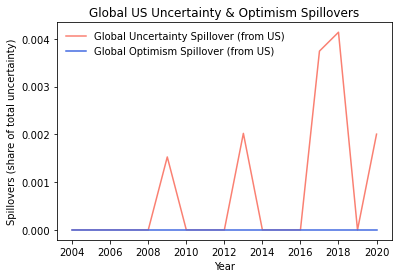

<Figure size 432x288 with 0 Axes>

In [161]:
year = df_spill_all_year['year']
uncertainty_spillover_us = df_spill_all_year['uncertainty_from_us']
optimism_spillover_us = df_spill_all_year['optimism_from_us']

# Generate plot
fig14 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, uncertainty_spillover_us, 'salmon', label = 'Global Uncertainty Spillover (from US)')
plt.plot(year, optimism_spillover_us, 'royalblue', label = 'Global Optimism Spillover (from US)')
plt.title('Global US Uncertainty & Optimism Spillovers')
plt.xlabel('Year')
plt.ylabel('Spillovers (share of total uncertainty)')
leg = ax.legend(frameon=False, loc='upper left')
plt.show()
plt.savefig(output_path + '20_uncertainty_optimism_us.png')

## Spillover Robustness Check
- We conduct a robustness check for the total spillovers per year using 5 randomly chosen alternatives for 'uncertainty' and 'optimism', respectively.

In [162]:
# Robustness: total spillovers per year using randomly chosen alternatives for 'uncertainty' and 'optimism'

# 1) Generate dataframe for robust spillovers
df_spill_all_year_robust = pd.DataFrame()

# 2) Group reports by year and sum up the number of keywords, uncertainty- and optimism words for every keyword country
for country in countries:
    df_spill_all_year_robust['no_uncertainty_robust_%s' % country] = df_spill.groupby(['year'])['no_uncertainty_robust_%s' % country].sum()
    df_spill_all_year_robust['no_optimism_robust_%s' % country] = df_spill.groupby(['year'])['no_optimism_robust_%s' % country].sum()
    
# 3) Create 'year' variable and put it to the front of the dataframe
df_spill_all_year_robust['year'] = df_spill_all_year_robust.index
df_spill_all_year_robust.reset_index(drop=True, inplace=True)
cols = [df_spill_all_year_robust.columns[-1]] + [col for col in df_spill_all_year_robust if col != df_spill_all_year_robust.columns[-1]]
df_spill_all_year_robust = df_spill_all_year_robust[cols]

# 4) Add the total number of 'uncertainty' and 'optimism'(and their variants) to the dataframe, respectively.
df_spill_all_year_robust['uncertainty_year_r3'] = df_year_uncertainty['uncertainty_year_r3'].values
df_spill_all_year_robust['optimism_year_r3'] = df_year_optimism['optimism_year_r3'].values


# 5) Create yearly spillovers by dividing the number of uncertainty- and optimism words by the number of keywords, respectively (for every keyword country)
for country in countries:    
    df_spill_all_year_robust['uncertainty_robust_from_%s' % country] = ((df_spill_all_year_robust['no_uncertainty_robust_%s' % country] 
                                                                         / df_spill_all_year_robust['uncertainty_year_r3']).fillna(0)) # spillover
    
    df_spill_all_year_robust['optimism_robust_from_%s' % country] = ((df_spill_all_year_robust['no_optimism_robust_%s' % country] 
                                                                      / df_spill_all_year_robust['optimism_year_r3']).fillna(0)) # spillover
     
# 6) Keep only spillover columns
df_spill_all_year_robust = df_spill_all_year_robust[df_spill_all_year_robust.columns.drop(list(df_spill_all_year_robust.filter(regex='no_')))]

#export to csv
df_spill_all_year.to_csv(output_path + r'spillovers_all_robust.csv', index = False)

df_spill_all_year_robust

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,uncertainty_year_r3,optimism_year_r3,uncertainty_robust_from_us,optimism_robust_from_us,uncertainty_robust_from_cn,optimism_robust_from_cn,uncertainty_robust_from_uk,optimism_robust_from_uk,uncertainty_robust_from_ca,optimism_robust_from_ca,uncertainty_robust_from_fr,optimism_robust_from_fr,uncertainty_robust_from_de,optimism_robust_from_de,uncertainty_robust_from_it,optimism_robust_from_it,uncertainty_robust_from_ja,optimism_robust_from_ja
0,2004,485,3486,0.000000,0.000000,0.000000,0.000287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000287,0.000000,0.000574,0.000000,0.000000,0.000000,0.000287
1,2005,462,3448,0.000000,0.000000,0.000000,0.001160,0.000000,0.000000,0.000000,0.000580,0.000000,0.000290,0.000000,0.000000,0.000000,0.000290,0.000000,0.000000
2,2006,410,3233,0.000000,0.000000,0.000000,0.000309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000309,0.000000,0.000000,0.000000,0.000000
3,2007,387,3026,0.000000,0.000000,0.000000,0.000661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2008,536,3637,0.000000,0.000000,0.000000,0.000550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000275,0.000000,0.000550,0.000000,0.000000,0.000000,0.000275
5,2009,730,3949,0.001370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000253,0.000000,0.000000,0.000000,0.000000
6,2010,745,4241,0.000000,0.000000,0.000000,0.000707,0.000000,0.000000,0.001342,0.000236,0.001342,0.000000,0.000000,0.000236,0.001342,0.000236,0.000000,0.000236
7,2011,724,3947,0.000000,0.000000,0.000000,0.000507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000507,0.000000,0.000000,0.000000,0.000000
8,2012,831,4700,0.001203,0.000000,0.000000,0.000638,0.000000,0.000000,0.000000,0.000213,0.000000,0.000000,0.000000,0.000213,0.001203,0.000638,0.000000,0.000000
9,2013,1034,4979,0.001934,0.000000,0.000000,0.001205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000201,0.000000,0.000402


/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 576x288 with 0 Axes>

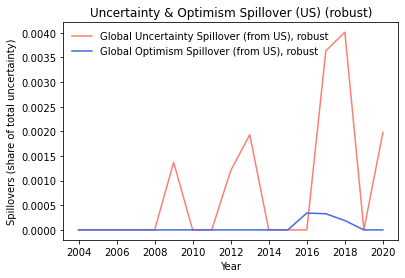

<Figure size 432x288 with 0 Axes>

In [164]:
year = df_spill_all_year_robust['year']
uncertainty_spillover_us_robust = df_spill_all_year_robust['uncertainty_robust_from_us']
optimism_spillover_us_robust = df_spill_all_year_robust['optimism_robust_from_us']

# Generate plot
fig15 = plt.figure(figsize=(8,4))
fig, ax = plt.subplots()
plt.plot(year, uncertainty_spillover_us_robust, 'salmon', label = 'Global Uncertainty Spillover (from US), robust')
plt.plot(year, optimism_spillover_us_robust, 'royalblue', label = 'Global Optimism Spillover (from US), robust')
plt.title('Uncertainty & Optimism Spillover (US) (robust)')
plt.xlabel('Year')
plt.ylabel('Spillovers (share of total uncertainty)')
leg = ax.legend(frameon=False, loc='upper left')
plt.show()

plt.savefig(output_path + '21_uncertainty_optimism_us_robust.png')

# Sentiment analysis

## Index Economic Outlook

### Clean text column

Picault M., Renault T. (2017), Words are not all created equals : a new measure of ECB communication, Journal of International Money and Finance, 79, 136-156. 

For each of the 7,333 individual sentences, we follow a standard textual analysis methodology by <br>
(i) converting all words to lower case, removing numbers and punctuation <br>
(ii) using a Porter (1980) stemming algorithm [...] and <br>
(iii) removing a set of 32 stop words

#### Converting all words to lower case, removing numbers and punctuation and removing stop words 

In [331]:
# import data
df = pd.read_csv(input_path + "01_reports_long.csv", encoding = "ISO-8859-1", index_col=False)
#df = pd.read_csv(input_path + "02_reports_short.csv", encoding = "ISO-8859-1", index_col=False)

#'''
# Prepare sample
print("Full sample:", df.shape)
# keep only 
df_nlp = df.loc[df['use_nlp'] == 1]
print("Shape w/ NaN:", df_nlp.shape)

# Article IV reports
df_nlp_iv = df_nlp.loc[df['article_four'] == 1]
print("Shape w/ NaN, IV:", df_nlp_iv.shape)

# drop missing values in report_text
df_nlp_iv_nan = df_nlp_iv.dropna(subset=['report_text'])
print("Shape w/o NaN, IV:", df_nlp_iv_nan.shape)

# rename dataframe 
df = df_nlp_iv_nan

# keep columns
df = df[["report_id", "country", "year", "report_text"]].copy()
print("Shape final sample:", df.shape)
#'''
def clean_text(text):
    text_nonum = re.sub(r'\d+', '', text) # removes numbers
    text_nopunct = re.sub(r'[^\w\s]','', text_nonum) # removes punctuation
    text_line = text_nopunct.strip().replace('\n', ' ') # removes line spacing
    text_apostr = text_line.strip().replace('ÃÂÂ', ' ') # removes unidentified apostrophes
    text_nodoublespace = re.sub('\s+', ' ', text_apostr).strip()  # removes all spaces but single spaces
    return text_nodoublespace

df['report_text_clean'] = df['report_text'].apply(lambda x: clean_text(x))

df.report_text_clean.head()

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:32: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
<ipython-input-331-baa356b43f94>:32: DeprecationWarning: invalid escape sequence \s
  text_nodoublespace = re.sub('\s+', ' ', text_apostr).strip()  # removes all spaces but single spaces


Full sample: (8185, 23)
Shape w/ NaN: (1844, 23)
Shape w/ NaN, IV: (1844, 23)
Shape w/o NaN, IV: (1844, 23)
Shape final sample: (1844, 4)


402    IMF Country Report No KINGDOM OF THE NETHERLAN...
406    IMF Country Report No ISLAMIC REPUBLIC OF AFGH...
423    IMF Country Report No REPUBLIC OF ARMENIA ARTI...
436    IMF Country Report No AUSTRALIA ARTICLE IV CON...
438    IMF Country Report No AUSTRALIA ARTICLE IV CON...
Name: report_text_clean, dtype: object

In [ ]:
# List of common stop words from Glasgow computer scientists
#Retrieved from: [The Programming Historian](https://programminghistorian.org/en/lessons/counting-frequencies)

stopwords = ['a', 'afterwards'] # exclude 'about', 'after','across','above',  
stopwords += ['almost', 'alone'] # exclude 'again', 'against', 'all', 'along'
stopwords += ['already', 'also', 'always', 'am', 'among'] # exclude 'although',  
stopwords += ['amongst', 'amoungst', 'an', 'and', 'another'] # exclude 'amount',   
stopwords += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']  
stopwords += ['are', 'as', 'at'] # exclude 'around','back','be', 'became'   
stopwords += ['because'] # exclude 'become', 'becomes', 'becoming', 'been'  
stopwords += ['being'] # exclude 'before', 'beforehand', 'below', 'behind',  
stopwords += ['beside', 'besides', 'beyond', 'bill'] # exclude 'between', 'both'  
stopwords += ['by'] # exclude 'but', 'bottom', 'call', 'can', 'cannot', 'cant'    
stopwords += ['co', 'cry', 'de'] # exclude 'computer', 'con', 'could', 'couldnt',  
stopwords += ['describe', 'did', 'done'] # exclude 'do', 'due' 'detail', 'down',  
stopwords += ['during', 'each', 'eg', 'eight', 'either', 'eleven'] # exclude , 'else'
stopwords += ['empty', 'enough', 'etc', 'ever'] # exclude 'elsewhere', 'even',   
stopwords += ['every', 'everyone', 'everything', 'everywhere'] # exclude , 'except'
stopwords += ['fifteen', 'fifty', 'fill', 'find', 'fire'] # exclude 'few', 'first' 
stopwords += ['for', 'former', 'formerly', 'forty', 'found'] # exclude 'five',   
stopwords += ['from', 'front', 'get', 'give'] # exclude   'full','four', 'further', 
stopwords += ['go', 'has', 'hasnt', 'he', 'hence', 'her'] # exclude  'have','had', 
stopwords += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
stopwords += ['herself', 'him', 'himself', 'his', 'how'] # exclude , 'however' 
stopwords += ['hundred', 'i', 'ie', 'in', 'inc', 'indeed'] # exclude 'if',  
stopwords += ['is', 'it', 'its', 'itself'] # exclude  'interest','into', 'keep'
stopwords += ['latter', 'latterly', 'ltd'] # exclude 'last', 'least', 'less', , 'made'  
stopwords += ['may', 'me', 'meanwhile', 'might', 'mill', 'mine'] # exclude 'many', 
stopwords += ['move'] # exclude , 'much', 'most', 'mostly','more', 'moreover',   
stopwords += ['my', 'myself', 'name', 'namely', 'neither', 'never'] # exclude 'must',   
stopwords += ['nevertheless', 'next', 'nine', 'nobody'] # exclude 'no', 'none'  
stopwords += ['noone', 'nor', 'now', 'nowhere', 'of'] # exclude  'not','nothing',  
stopwords += ['often', 'on','only', 'onto', 'or'] # exclude 'off','one','once',    
stopwords += ['our', 'ours', 'ourselves'] # exclude 'other', 'others', 'otherwise', 
stopwords += ['own','per', 'perhaps', 'please'] # exclude 'out', 'over', 'part',   
stopwords += ['put', 'rather', 're', 's'] # exclude , 'seem', 'seemed' , 'see', 'same' 
stopwords += ['she'] # exclude 'seeming', 'seems', 'serious', 'several', , 'should'   
stopwords += ['six', 'sixty'] # exclude 'since', 'sincere', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'system', 'take', 'such', 'still' , 'so', 'show', 'side', 
stopwords += ['ten', 'than', 'that', 'the','them', 'themselves'] # exclude  'their', 
stopwords += ['then', 'thence'] # exclude , 'there', 'thereafter', 'thereby'
stopwords += ['they'] # exclude 'therefore', 'these', 'therein', 'thereupon',   
stopwords += ['third', 'this', 'those', 'though', 'three'] # exclude 'thick', 'thin',  
stopwords += ['three', 'thru', 'to'] # exclude 'thus', 'through', 'throughout',   
stopwords += ['too', 'top', 'twelve'] # exclude 'together', 'toward', 'towards', 
stopwords += ['twenty', 'un'] # exclude 'under', 'until', 'up', 'upon' 'two',    
stopwords += ['us', 'very', 'via', 'was', 'we', 'were', 'what'] # exclude 'well',  
stopwords += ['whatever', 'whence', 'whenever', 'where'] # exclude 'when',  
stopwords += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon'] # exclude 
stopwords += ['wherever', 'whether', 'whither', 'who'] # exclude 'which', 'while',  
stopwords += ['whoever', 'whom', 'whose', 'why', 'with'] # exclude 'will', 'whole',   
stopwords += ['would', 'you', 'your'] # exclude 'within', 'without', 'yet',  
stopwords += ['yours', 'yourself', 'yourselves'] # exclude 

#### Using a Porter (1980) stemming algorithm

In [ ]:
# stem text
ps = PorterStemmer()
df["report_text_stemmed"] = df["report_text_clean"].apply(lambda x: " ".join([ps.stem(t) for t in x.split()]))
df.head()

In [ ]:
# repeat the code above with stemmed text:
rx = '[a-zA-Z]{2,20}'
cv = CountVectorizer(max_df=1.0, min_df=0.01, max_features=100000, stop_words=stopwords, token_pattern = rx, ngram_range=(1,2)) 
#cv = CountVectorizer(max_df=1.0, min_df=0.1, max_features=100000, stop_words=stopwords, token_pattern = rx, ngram_range=(1,10)) 
cvf = cv.fit_transform(df["report_text_stemmed"])

In [ ]:
shape = cvf.toarray().shape
print('Shape of document term matrix: ', shape)
print('Print all stemmed n-grams from report_text:\n', cv.get_feature_names())

In [ ]:
cvf_matrix = pd.DataFrame(cvf.toarray(), columns=cv.get_feature_names())
cvf_matrix.head()

### Sentiment Analysis Using the CBCI Lexicon


Picault M., Renault T. (2017), Words are not all created equals : a new measure of ECB communication, Journal of International Money and Finance, 79, 136-156. 

_We aggregate the information content of the introductory statement into two indicators. We define [...] variables labeled [...] $I_S^{EC}$ by computing, for each statement s, the difference between the positive and the negative probability._

In [ ]:
# Import lexicon
df_lexicon = pd.read_csv(input_path + "CBCI_export_lexicon.csv", sep = ';')
df_lexicon.head()

In [ ]:
# Get shape of generated data frame
df_lexicon.shape

In [ ]:
# Check if string is in lexicon and get positive value
string = 'abov level'

df_lexicon[df_lexicon.keyword==string].ec_posi

In [ ]:
# Check if string is in documents 
string = 'abov level'

cvf_matrix.loc[cvf_matrix[string]> 0, string]

In [ ]:
# Create a new dataframe
df_ec_posi = pd.DataFrame()
df_ec_nega = pd.DataFrame()
df_ec_neut = pd.DataFrame()
# create array for positive weights
weigh_posi = [] 
weigh_nega = []
weigh_neut = []  
# All columns types should be string
cvf_matrix.select_dtypes("string")

# Loop through columns of document term matrix 
# get value for n-gram if matched in lexicon
# add values to an array, zero if no match
for col in cvf_matrix.columns:
    string = col
    if string in df_lexicon.keyword.values:
        string_index = (df_lexicon.keyword == string).argmax() # get index for match in lexicon
        ec_value_posi = df_lexicon.at[string_index, 'ec_posi'] 
        weigh_posi.append(ec_value_posi) # append positive weight for match to array positive
        ec_value_nega = df_lexicon.at[string_index, 'ec_nega']
        weigh_nega.append(ec_value_nega) # append negative weight for match to array negative
        ec_value_neut = df_lexicon.at[string_index, 'ec_neut']
        weigh_neut.append(ec_value_neut) # append neutral weight for match to array neutral
    else: 
        weigh_posi += [0]
        weigh_nega += [0]
        weigh_neut += [0]

print('Loop successful.')
print('Number of matched n-grams: % .0f' % np.count_nonzero(weigh_posi))

In [ ]:
# Get sum of weighted counts of all n-grams for every report
print('Length of positive weights array: % .0f' % len(weigh_posi))
shape = cvf_matrix.shape
print('Shape of document term matrix: ', shape)

print('Get sum of weighted counts of all n-grams for every report...')
df_ec_posi = cvf_matrix.dot(weigh_posi)
print('Index\tIndex for positivity of report\n',df_ec_posi.head())
df_ec_nega = cvf_matrix.dot(weigh_nega)
print('Index\tIndex for negativity of report\n', df_ec_nega.head())
df_ec_neut = cvf_matrix.dot(weigh_neut)
print('Index\tIndex for neutrality of report\n', df_ec_neut.head())

In [ ]:
# Combine to 3 economic outlook indices
df_ec = pd.DataFrame([df.report_id, df.country, df.year]).transpose()
df_ec = df_ec.reset_index()

df_ec['ec_posi_index_report'] = df_ec_posi
df_ec['ec_nega_index_report'] = df_ec_nega
df_ec['ec_neut_index_report'] = df_ec_neut
print('Shape: ', df_ec.shape)

#df_ec.loc[df_ec['year'] == '2015']
#df_ec.loc[df_ec['country'] == 'Germany']
df_ec.head(10)


In [ ]:
# Combined economic outlook index (positive - negative)
df_ec['ec_index'] = df_ec['ec_posi_index_report'] - df_ec['ec_nega_index_report']

df_ec.head(10)

In [ ]:
# Export to .csv-file
df_ec.to_csv(output_path + r'ec_2grams.csv', index = False)
#df_ec.to_csv(output_path + r'ec_bigrams_test.csv', index = False)

### Figure

In [ ]:
# Import csv-file
df_ec = pd.read_csv(output_path + "ec_2grams.csv")
df_ec.year = df_ec.year.astype(int) # year to integer - w/o decimals
print('Shape w/ scans: ', df_ec.shape)

df_ec.head()

In [ ]:
# Generate index per country per year

# Generate dataframe
df_country_year_ec = pd.DataFrame()

# Generate positive index value per country per year
df_country_year_ec['index_posi_year_country'] = df_ec.groupby(['country', 'year'])['ec_posi_index_report'].sum()
# Generate negative index value per country per year
df_country_year_ec['index_nega_year_country'] = df_ec.groupby(['country', 'year'])['ec_nega_index_report'].sum()
# Generate neutral index value per country per year
df_country_year_ec['index_neut_year_country'] = df_ec.groupby(['country', 'year'])['ec_neut_index_report'].sum()
# Generate Economic Outlook Index value per country per year
df_country_year_ec['ec_index_year_country'] = df_ec.groupby(['country', 'year'])['ec_index'].sum()

df_country_year_ec = df_country_year_ec.reset_index()

# Generate unique merge ID
df_country_year_ec['year'] = df_country_year_ec['year'].map(str)
df_country_year_ec['country_year_id'] = df_country_year_ec['country'] + '_' + df_country_year_ec['year']


df_country_year_ec.head(100)
df_country_year_ec.loc[df_country_year_ec['country'] == 'Germany']#.shape

In [ ]:
# Add GDP data
df_gdp = pd.read_csv(input_path + r"03_gdp.csv")
df_gdp = df_gdp[['country_year_id', 'share_r_gdp']]
print("Shape GDP Input w/ duplicates:", df_gdp.shape)
df_gdp = df_gdp.drop_duplicates()
print("Shape GDP Input w/o duplicates:", df_gdp.shape)

df_merged_gdp = df_country_year_ec.merge(df_gdp, left_on = 'country_year_id', right_on = 'country_year_id', how = 'outer')
print("Shape merged Input w/ missing values:", df_merged_gdp.shape)
df_merged_gdp = df_merged_gdp.dropna() # drop rows where share_r_gdp == NAN
print("Shape merged Input w/o missing values:", df_merged_gdp.shape)

df_merged_gdp.head()

In [ ]:
# Generate weighted index over time (i.e. aggregate over countries in given year)

# Multiply index values with share in world real GDP 
df_merged_gdp['index_value_multi_posi'] = df_merged_gdp['index_posi_year_country'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_multi_nega'] = df_merged_gdp['index_nega_year_country'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['index_value_multi_neut'] = df_merged_gdp['index_neut_year_country'] * df_merged_gdp['share_r_gdp']
df_merged_gdp['ec_index_multi'] = df_merged_gdp['ec_index_year_country'] * df_merged_gdp['share_r_gdp']

# Aggregate weighted index over time
df_ec_index_time_weighted = pd.DataFrame()
df_ec_index_time_weighted['index_value_weighted_posi'] = df_merged_gdp.groupby(['year'])['index_value_multi_posi'].sum()
df_ec_index_time_weighted['index_value_weighted_nega'] = df_merged_gdp.groupby(['year'])['index_value_multi_nega'].sum()
df_ec_index_time_weighted['index_value_weighted_neut'] = df_merged_gdp.groupby(['year'])['index_value_multi_neut'].sum()
df_ec_index_time_weighted['ec_index_weighted'] = df_merged_gdp.groupby(['year'])['ec_index_multi'].sum()

df_ec_index_time_weighted = df_ec_index_time_weighted.reset_index()

# Drop row 2020 (gdp == 0)
df_ec_index_time_weighted = df_ec_index_time_weighted[(df_ec_index_time_weighted != 0).all(1)]

df_ec_index_time_weighted

In [ ]:
# Plot positive index over time (Index Economic Outlook)

# Sort dataframe according to year
df_ec_index_time_weighted = df_ec_index_time_weighted.sort_values(by = ['year'], ascending = True)

# Assign plot contents
year = df_ec_index_time_weighted['year']
index_value_weighted_posi = df_ec_index_time_weighted['index_value_weighted_posi']
index_value_weighted_nega = df_ec_index_time_weighted['index_value_weighted_nega']
ec_index_weighted = df_ec_index_time_weighted['ec_index_weighted']
index_value_weighted_posi_mean = df_ec_index_time_weighted['index_value_weighted_posi'].mean()
index_value_weighted_nega_mean = df_ec_index_time_weighted['index_value_weighted_nega'].mean()
ec_index_weighted_mean = df_ec_index_time_weighted['ec_index_weighted'].mean()

# Generate plot
plt.plot(year, index_value_weighted_posi, 'cornflowerblue') # Index positive 
plt.plot(year, index_value_weighted_nega, 'forestgreen') # Index negative
plt.plot(year, ec_index_weighted, 'darkorange') # Index 
plt.axhline(y = index_value_weighted_posi_mean,linewidth = 1, color = 'lightsteelblue', linestyle = '--')
plt.axhline(y = index_value_weighted_nega_mean,linewidth = 1, color = 'limegreen', linestyle = '--')
plt.axhline(y = ec_index_weighted_mean,linewidth = 1, color = 'salmon', linestyle = '--')
plt.title('ECO (weighted)')
plt.xticks(rotation=45, ha='right')

plt.savefig(output_path + r'ec index _ time _ weighted _ 2full.png')

In [ ]:
#export to csv
df_ec_index_time_weighted.to_csv(output_path + r'ec_index_time_weighted.csv', index = False)

# Topic Modelling using LDA  

In [256]:
#import data
df = pd.read_csv(input_path + "02_reports_short.csv", encoding = "ISO-8859-1", index_col=False)
print(df.shape)
#df['report_text'][0]

/Applications/miniconda3/envs/snowflakes/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1824, 6)


## Cleaning

In [ ]:
def clean_text(text):
    text_nonum = re.sub(r'\d+', '', str(text)) # removes numbers
    text_nopunct = re.sub(r'[^\w\s]','', text_nonum) # removes punctuation
    text_line = text_nopunct.strip().replace('\n', ' ') # removes line spacing
    text_apostr = text_line.strip().replace('ÃÂÂ', ' ') # removes unidentified apostrophes
    text_nodoublespace = re.sub('\s+', ' ', text_apostr).strip()  # removes all spaces but single spaces
    return text_nodoublespace

df['report_text_clean'] = df['report_text'].apply(lambda x: clean_text(x))

#df.report_text_clean[0]

**Convert into lowercase tokens, remove stopwords, lemmatize**

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data_words = list(sent_to_words(df['report_text_clean']))

print(data_words[:1])

In [ ]:
# Define functions for stopwords, lemmatization
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [ ]:
## LDA model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [ ]:
# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,      #choose no. of topics
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model.print_topics()

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_1 = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis_1

## WordCloud

In [ ]:
#top 40 most salient words spanning all topics
most_salient_words= vis_1.topic_info[0:30]
print(most_salient_words)

In [ ]:
default_sample= most_salient_words.drop(most_salient_words.columns[[2,3,4,5]], axis=1)
default_sample=default_sample.reset_index(drop=True)
default_sample

In [ ]:
list1=default_sample['Term'].to_list()
list2=default_sample['Freq'].to_list()
list_tuple = list(zip(list1,list2))
list_tuple=dict(list_tuple)
list_tuple

In [ ]:
#wordcloud for top 30 most salient words
wordcloud= WordCloud(background_color='white',width=2500,height=1800,max_words=100,colormap='tab10',prefer_horizontal=1.0).generate_from_frequencies(list_tuple,max_font_size=500)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()
#wordcloud.to_file (output_path + 'wordcloud.png' )